# Notebook for generating plots in the paper

In [1]:
%reload_ext autoreload
%autoreload 2
# %pip install diptest
# %pip install matplotlib-venn
# %pip install SciencePlots
## %pip install upsetplot
# %pip install statsmodels

## Config

Specify the data directories to be processed

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from timkf.misc import plot_medians_hist, calculate_auto_bin_sizes
from timkf.misc import is_recycled_millisecond, is_magnetar, B_surf, tau_eff_squared
from timkf.misc.polars_lib import (
    cast_parenthetical_expr_to_valerr,
    format_valerr_expr_to_latex,
    format_valerr_to_latex,
)
import diptest  # for checking unimodality
import scienceplots  # noqa

plt.style.use("science")  # use science plots style from scienceplots
plt.rcParams.update({"font.size": 11})

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_table_cell_list_len(-1)

UTMOST_DATA_DIR = "../data/TimingDataRelease1/pulsars"
RESULTS_DIR = "../results-utmost/outdirDR1nlive2e3/s917-nw20-r8-tau2_9-Qc30_14-Qs30_14-lag2-EFAC0_4-EQUAD40_2-omgc_0"
ATNF_GLITCH_TABLE = "../data/atnf_glitch_table-20250609.csv"
SAVE_PLT_TBL = False
STRONG_BF_THRESH = 5  # a common natural log Bayes factor threshold for strong evidence

Numpy version is compatible with longdouble.
np.finfo(np.longdouble).eps 2.220446049250313e-16
np.longdouble is equivalent to np.float64.
Downcasting to np.float64.
Using NP_LONGDOUBLE_TYPE: <class 'numpy.float64'>


### Identify pulsars with glitches before, during, and after the UTMOST observations

Read in the manually copied `ATNF_GLITCH_TABLE`

In [3]:
df_glitch_atnf = pl.read_csv(ATNF_GLITCH_TABLE, separator="\t", has_header=True)
df_glitch_atnf = df_glitch_atnf.drop(["PSR"])
# df_glitch_atnf = df_glitch_atnf.drop(["PSR", "Δν/ν (10-9)", "Δν·/ν· (10-3)"])

Fill the PSR and PSRJ columns with their previous values when missing

In [4]:
## first replace - with None
df_glitch_atnf = df_glitch_atnf.with_columns(
    [
        pl.when(pl.col(col) == "-").then(None).otherwise(pl.col(col)).alias(col)
        for col in df_glitch_atnf.columns
    ]
).with_row_index()
## then fill null with the previous values for only PSR, PSRJ, and GLEP (MJD)
df_glitch_atnf = df_glitch_atnf.with_columns(
    pl.col("PSRJ", "GLEP (MJD)").fill_null(strategy="forward")
)

df_glitch_atnf_GLEP_grouped = (
    cast_parenthetical_expr_to_valerr(df_glitch_atnf, "GLEP (MJD)")
    .group_by("PSRJ")
    .agg(pl.col("GLEP (MJD) val"))
)

### Read in `model_comparison.csv`

In [5]:
csv_name = os.path.join(RESULTS_DIR, "model_comparison.csv")
df_PE = pl.read_csv(csv_name)

for p in ["tau", "Qc", "Qs", "TN", "ratio", "taueff"]:
    # convert the logq columns from string to list of floats
    df_PE = df_PE.with_columns(
        pl.col(f"logq_{p}")
        .str.json_decode()
        .list.eval(pl.element().cast(pl.Float64))
        .alias(f"logq_{p}")
    )
    # get the median (1st element of the list)
    df_PE = df_PE.with_columns(pl.col(f"logq_{p}").list.get(0).alias(f"log{p}_med"))
    # get the 68% error
    df_PE = df_PE.with_columns(
        (
            pl.col(f"logq_{p}").list.get(1).cast(pl.Float64)
            - pl.col(f"logq_{p}").list.get(0).cast(pl.Float64)
        ).alias(f"log{p}_68err_low"),
    ).with_columns(
        (
            pl.col(f"logq_{p}").list.get(2).cast(pl.Float64)
            - pl.col(f"logq_{p}").list.get(0).cast(pl.Float64)
        ).alias(f"log{p}_68err_upp"),
    )
    df_PE = df_PE.with_columns(
        pl.struct(
            [
                f"log{p}_68err_low",
                f"log{p}_68err_upp",
            ]
        ).alias(f"log{p}_68err")
    ).drop(f"log{p}_68err_low", f"log{p}_68err_upp")

# recast the column names
df_PE = df_PE.with_columns(
    pl.col("logBF_2Cmpnt_vs_WTNnullHypothesis").alias("lnBF"),
).drop("logBF_2Cmpnt_vs_WTNnullHypothesis")
# drop other unnecessary columns
df_PE = df_PE.drop(
    "log_evidence_2Cmpnt",
    "log_evidence_WTNnullHypothesis",
    "logBF_per_TOA_2Cmpnt_vs_WTNnullHypothesis",
    "log_ratio-dist",
)
print(f"{df_PE.columns=}")

# Filter the dataframe with strong Bayes factor, typically lnBF > 5
df_lnBF5 = df_PE.filter(pl.col("lnBF") > STRONG_BF_THRESH)

df_PE.columns=['PSRJ', 'omgc_dot', 'omgc_0', 'logq_taueff', 'logq_tau', 'logq_ratio', 'logq_TN', 'logq_Qs', 'logq_Qc', 'log_tau-dist', 'log_Qs-dist', 'log_Qc-dist', 'Tobs', 'TSTART', 'TFINISH', 'NTOAs', 'logtau_med', 'logtau_68err', 'logQc_med', 'logQc_68err', 'logQs_med', 'logQs_68err', 'logTN_med', 'logTN_68err', 'logratio_med', 'logratio_68err', 'logtaueff_med', 'logtaueff_68err', 'lnBF']


In [6]:
df_PE["lnBF"].describe()

statistic,value
str,f64
"""count""",293.0
"""null_count""",0.0
"""mean""",74.797499
"""std""",239.469531
"""min""",-3.382787
"""25%""",-1.542619
"""50%""",0.33503
"""75%""",30.394886
"""max""",2536.851839


#### Make sure pulsars that glitched between the start and finish epoch of UTMOST campaign are not included.

In [7]:
# filter matching pulsars in the glitch data
# common pulsars between atnf glitch table and PE results
df_temp2 = df_glitch_atnf_GLEP_grouped.join(df_PE, on="PSRJ", how="inner")[
    "PSRJ", "TSTART", "TFINISH", "GLEP (MJD) val"
]
# check if the GLEP of glitching pulsars lies within the start and finish epoch
df_temp2 = df_temp2.with_columns(
    pl.struct(["GLEP (MJD) val", "TSTART", "TFINISH"])
    .map_elements(
        lambda row: any(
            (row["TSTART"] < glep) & (glep < row["TFINISH"])
            for glep in row["GLEP (MJD) val"]
        )
    )
    .alias("glep_during_timing")
)
# pulsars that glitched during UTMOST timing campaign
df_gl_during = df_temp2.filter(pl.col("glep_during_timing"))
df_gl_during_with_lnBF5 = df_gl_during.filter(pl.col("PSRJ").is_in(df_lnBF5["PSRJ"]))
# pulsars that glitched outside UTMOST timing campaign
df_gl_outside = df_temp2.filter(~pl.col("glep_during_timing"))

## drop the extra glitching pulsars from df_PE and df_lnBF5
df_PE = df_PE.filter(~pl.col("PSRJ").is_in(df_gl_during["PSRJ"]))
df_lnBF5 = df_lnBF5.filter(~pl.col("PSRJ").is_in(df_gl_during["PSRJ"]))
print(
    f"Dropped extra glitching pulsars during UTMOST:\n{df_gl_during['PSRJ'].to_list()}"
)
print(
    f"Dropped extra glitching pulsars with lnBF > 5:\n{df_gl_during_with_lnBF5['PSRJ'].to_list()}"
)

Dropped extra glitching pulsars during UTMOST:
['J0820-1350', 'J1705-1906', 'J1825-0935', 'J1835-1020', 'J1845-0743', 'J1847-0402', 'J2346-0609']
Dropped extra glitching pulsars with lnBF > 5:
['J0820-1350', 'J1705-1906', 'J1825-0935', 'J1835-1020', 'J1847-0402', 'J2346-0609']


/var/folders/0f/w1j_z2b96f53kqjcj06c8yrw0000gn/T/ipykernel_46091/85503088.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_temp2 = df_temp2.with_columns(


In [8]:
print(
    f"Number of pulsars with 0<lnBF<STRONG_BF_THRESH: {len(df_PE.filter(pl.col('lnBF') >= 0)) - len(df_lnBF5)}"
)
print(
    f"Number of pulsars with -3<lnBF<0: {len(df_PE.filter(pl.col('lnBF') < 0)) - len(df_PE.filter(pl.col('lnBF') < -3))}"
)

Number of pulsars with 0<lnBF<STRONG_BF_THRESH: 37
Number of pulsars with -3<lnBF<0: 143


Check the number of peaky tau distributions and filter out special cases for future convenience

In [9]:
# Check the number of peaky tau distributions
print(df_lnBF5["log_tau-dist"].value_counts())
df_lnBF5_pkytau = df_lnBF5.filter(pl.col("log_tau-dist") == "pky")
df_lnBF5_rrtau = df_lnBF5.filter(pl.col("log_tau-dist") == "rr")

shape: (3, 2)
┌──────────────┬───────┐
│ log_tau-dist ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ pky          ┆ 28    │
│ rr           ┆ 13    │
│ -            ┆ 64    │
└──────────────┴───────┘


Histograms of medians of some two-component model parameters for all $293-7=286$ objects and $111-6=105$ objects with $\ln \mathfrak{B} >5$ 
(because original runs contains glitchy pulsars that wasn't detected by UTMOST)

/Users/Eric.Dong/Downloads/project-psrtim_population/src/timkf/misc/my_plot_lib.py:502: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


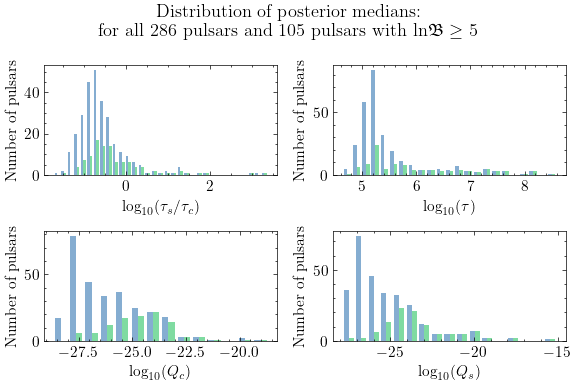

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
plot_params = [
    ("logratio_med", r"$\log_{10}(\tau_s / \tau_c)$"),
    ("logtau_med", r"$\log_{10}(\tau)$"),
    ("logQc_med", r"$\log_{10}(Q_c)$"),
    ("logQs_med", r"$\log_{10}(Q_s)$"),
]
for i, (col, xlabel) in enumerate(plot_params):
    ax = axs[i // 2, i % 2]
    plot_medians_hist(
        [df_PE[col], df_lnBF5[col]],
        ax=ax,
        xlabel=xlabel,
        ylabel="Number of pulsars",
        display_counts=False,
        show_title=False,
    )
plt.suptitle(
    "Distribution of posterior medians: \nfor all 286 pulsars and 105 pulsars with ln$\mathfrak{B}\geq $ 5",
)
plt.tight_layout()

##### Read in the result table by LowerEtAl(2020), later referred as `Lo20`

In [11]:
from timkf.cli.model_comparison import get_utmost_bayes_factor_table

df_Lo20 = pl.from_pandas(
    get_utmost_bayes_factor_table(
        "../data/TimingDataRelease1/utmost_supplementary_files/rednoise_table_B1.csv"
    )
)
df_Lo20_BF5 = df_Lo20.filter(pl.col("lnBF") > 5).filter(
    ~pl.col("PSRJ").is_in(df_gl_during_with_lnBF5["PSRJ"])
)
with pl.Config(set_tbl_cols=10, set_tbl_rows=2):
    print(df_lnBF5)
    print(
        f"{len(df_lnBF5.filter(pl.col('PSRJ').is_in(df_Lo20_BF5['PSRJ'])))} out of {df_lnBF5.shape[0]} pulsars with lnBF>5 in common with Lo20"
    )
    print(
        f"{df_Lo20_BF5.filter(~pl.col('PSRJ').is_in(df_lnBF5['PSRJ'])).shape[0]} objects in Lo20 with lnBF>5 but not in this work"
    )  # remember there are 7 extra glitching pulsars included in df_Lo20

shape: (105, 29)
┌─────────┬─────────┬─────────┬─────────┬─────────┬───┬────────┬────────┬────────┬────────┬────────┐
│ PSRJ    ┆ omgc_do ┆ omgc_0  ┆ logq_ta ┆ logq_ta ┆ … ┆ lograt ┆ lograt ┆ logtau ┆ logtau ┆ lnBF   │
│ ---     ┆ t       ┆ ---     ┆ ueff    ┆ u       ┆   ┆ io_med ┆ io_68e ┆ eff_me ┆ eff_68 ┆ ---    │
│ str     ┆ ---     ┆ f64     ┆ ---     ┆ ---     ┆   ┆ ---    ┆ rr     ┆ d      ┆ err    ┆ f64    │
│         ┆ f64     ┆         ┆ list[f6 ┆ list[f6 ┆   ┆ f64    ┆ ---    ┆ ---    ┆ ---    ┆        │
│         ┆         ┆         ┆ 4]      ┆ 4]      ┆   ┆        ┆ struct ┆ f64    ┆ struct ┆        │
│         ┆         ┆         ┆         ┆         ┆   ┆        ┆ [2]    ┆        ┆ [2]    ┆        │
╞═════════╪═════════╪═════════╪═════════╪═════════╪═══╪════════╪════════╪════════╪════════╪════════╡
│ J0401-7 ┆ -3.2630 ┆ 11.5234 ┆ [4.9755 ┆ [5.0133 ┆ … ┆ -0.645 ┆ {-2.40 ┆ 4.9755 ┆ {-2.42 ┆ 7.1546 │
│ 608     ┆ e-14    ┆ 07      ┆ 26, 2.5 ┆ 45, 2.9 ┆   ┆ 482    ┆ 564,3. ┆ 

For Section~4.3: key statistics of $\tau$

In [12]:
params_of_interests = ["logtau_med"]
for param in params_of_interests:
    print(f"Statistics for {param} in lnBF > 5 pulsars:")
    temp = df_lnBF5.select(
        pl.col("PSRJ", param).get(pl.col(param).arg_min())
    ).to_numpy()[0]
    print(
        f"MIN - PSR: {temp[0]}, {param}: {temp[1]:.2f}",
    )
    temp = df_lnBF5.select(
        pl.col("PSRJ", param).get(pl.col(param).arg_max())
    ).to_numpy()[0]
    print(f"MAX - PSR: {temp[0]}, {param}: {temp[1]:.2f}", end="\n\n")
    print(f"Statistics for {param} in lnBF > 5 and peaky tau pulsars:")
    temp = df_lnBF5_pkytau.select(
        pl.col("PSRJ", param).get(pl.col(param).arg_min())
    ).to_numpy()[0]
    print(
        f"MIN - PSR: {temp[0]}, {param}: {temp[1]:.2f}",
    )
    temp = df_lnBF5_pkytau.select(
        pl.col("PSRJ", param).get(pl.col(param).arg_max())
    ).to_numpy()[0]
    print(f"MAX - PSR: {temp[0]}, {param}: {temp[1]:.2f}", end="\n\n")
    print(f"Median for {param} in lnBF > 5 pulsars: {df_lnBF5[param].median():.2f}")
    print(
        f"Median for {param} in lnBF > 5 and peaky tau pulsars: {df_lnBF5_pkytau[param].median():.2f}"
    )

Statistics for logtau_med in lnBF > 5 pulsars:
MIN - PSR: J2241-5236, logtau_med: 4.64
MAX - PSR: J1741-3927, logtau_med: 8.59

Statistics for logtau_med in lnBF > 5 and peaky tau pulsars:
MIN - PSR: J2241-5236, logtau_med: 4.64
MAX - PSR: J1644-4559, logtau_med: 7.72

Median for logtau_med in lnBF > 5 pulsars: 5.65
Median for logtau_med in lnBF > 5 and peaky tau pulsars: 6.73


#### Histogram of the median of $\log (\tau \rm{s}^{-1})$ posteriors

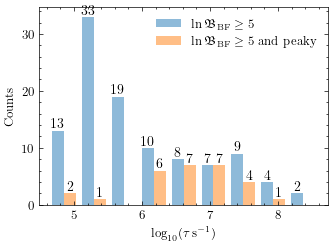

In [13]:
with plt.rc_context({"font.size": 9}):
    fig, ax = plt.subplots()
    bins105 = calculate_auto_bin_sizes([df_lnBF5["logtau_med"].to_numpy()])[0]
    plot_medians_hist(
        [df_lnBF5["logtau_med"], df_lnBF5_pkytau["logtau_med"]],
        ax,
        # bins=bins105,
        label=[
            "$\ln\mathfrak{B}_{\\rm BF} \geq 5$",
            "$\ln\mathfrak{B}_{\\rm BF} \geq 5$ and peaky",
        ],
        xlabel=r"$\log_{10}(\tau\,\rm{s}^{-1})$",
        show_title=False,
        display_counts=True,
        color=["tab:blue", "tab:orange"],
        counts_colors=["black", "black"],
    )

    plt.xlabel(r"$\log_{10}(\tau\,\rm{s}^{-1})$")
    plt.ylabel("Counts")
    plt.legend()
    plt.tight_layout()
    if SAVE_PLT_TBL:
        plt.savefig("../docs/paperplots/lnBF5_tau_histogram.pdf")
        # plt.savefig("../docs/paperplots/lnBF5_tau_histogram.png", dpi=300)


In [14]:
print("Objects with lnBF > 5 and peaky tau with tau_med < 1e6 s:")
df_lnBF5_pkytau.filter(pl.col("logtau_med") < 6)

Objects with lnBF > 5 and peaky tau with tau_med < 1e6 s:


PSRJ,omgc_dot,omgc_0,logq_taueff,logq_tau,logq_ratio,logq_TN,logq_Qs,logq_Qc,log_tau-dist,log_Qs-dist,log_Qc-dist,Tobs,TSTART,TFINISH,NTOAs,logtau_med,logtau_68err,logQc_med,logQc_68err,logQs_med,logQs_68err,logTN_med,logTN_68err,logratio_med,logratio_68err,logtaueff_med,logtaueff_68err,lnBF
str,f64,f64,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,str,f64,f64,f64,i64,f64,struct[2],f64,struct[2],f64,struct[2],f64,struct[2],f64,struct[2],f64,struct[2],f64
"""J0437-4715""",-1.0853e-14,1091.313546,"[1.926283, -0.032658, 3.242499]","[4.948697, 3.959795, 5.413139]","[3.057184, 2.106549, 3.721386]","[-10.466436, -10.891909, -9.663488]","[-27.675085, -29.215639, -26.095878]","[-21.936962, -22.820929, -19.974824]","""pky""","""-""","""pky""",502.624559,57939.987431,58442.611989,230,4.948697,"{-0.988902,0.464442}",-21.936962,"{-0.883967,1.962138}",-27.675085,"{-1.540554,1.579207}",-10.466436,"{-0.425473,0.802948}",3.057184,"{-0.950635,0.664201}",1.926283,"{-1.958941,1.316216}",65.654412
"""J1903-0632""",-1.1387e-13,14.548141,"[4.200859, 1.872198, 6.874425]","[5.27084, 3.363152, 7.170188]","[1.021259, -2.585269, 3.195715]","[-4.077633, -5.071993, -3.535475]","[-25.410821, -28.457315, -22.498758]","[-24.184124, -25.649868, -21.595751]","""pky""","""-""","""pky""",1116.920848,57274.438128,58391.358976,69,5.27084,"{-1.907688,1.899348}",-24.184124,"{-1.465744,2.588373}",-25.410821,"{-3.046494,2.912063}",-4.077633,"{-0.99436,0.542158}",1.021259,"{-3.606528,2.174456}",4.200859,"{-2.328661,2.673566}",9.699158
"""J2241-5236""",-9.0531e-15,2873.364412,"[0.712111, -0.756597, 2.034464]","[4.637667, 3.991755, 5.152099]","[3.373988, 2.671089, 3.817116]","[-9.230723, -9.632296, -8.490128]","[-27.370429, -29.135701, -25.541316]","[-19.559799, -20.605967, -18.274777]","""pky""","""-""","""pky""",1164.767684,57150.94466,58315.712343,295,4.637667,"{-0.645912,0.514432}",-19.559799,"{-1.046169,1.285022}",-27.370429,"{-1.765272,1.829112}",-9.230723,"{-0.401572,0.740595}",3.373988,"{-0.7029,0.443127}",0.712111,"{-1.468708,1.322353}",15.373779


#### Identify the recycled pulsars and magnetars

In [15]:
# add the columns for the recycled millisecond pulsar, magnetar, and canonical pulsar
df_PE = df_PE.with_columns(
    is_recycled_millisecond(
        pl.col("omgc_0") / (2 * np.pi), pl.col("omgc_dot") / (2 * np.pi)
    ).alias("msp"),
    is_magnetar(B_surf(pl.col("omgc_0"), pl.col("omgc_dot"))).alias("magnetar"),
)
## whatever is not msp or magnetar is canonical
df_PE = df_PE.with_columns(
    (~pl.col("msp") & ~pl.col("magnetar")).alias("canonical"),
)

# Filter the dataframe for different types of pulsars
df_msp = df_PE.filter(pl.col("msp")).drop("msp", "magnetar", "canonical")
df_magnetar = df_PE.filter(pl.col("magnetar")).drop("msp", "magnetar", "canonical")
df_canonical = df_PE.filter(pl.col("canonical")).drop("msp", "magnetar", "canonical")

Display the spans of parameters and their corresponding PSRJ

In [16]:
# Filter the canonical pulsars with lnBF > 5
df_canonical_lnBF5 = df_canonical.filter(pl.col("lnBF") > 5)
# Filter the canonical pulsars with lnBF > 5 and peaky tau
df_canonical_lnBF5_pkytau = df_canonical_lnBF5.filter(pl.col("log_tau-dist") == "pky")

display_cols = ["PSRJ", "logQc_med", "logQs_med", "logTN_med"]
for param in display_cols[1:]:
    print(f"Statistics for {param} in lnBF > 5 pulsars:")
    print(df_lnBF5.select(pl.col("PSRJ", param).get(pl.col(param).arg_min())))
    print(df_lnBF5.select(pl.col("PSRJ", param).get(pl.col(param).arg_max())))
    print(f"Median of {param} for lnBF>5: {df_lnBF5[param].median():.2f}")
    print(f"Statistics for {param} in lnBF > 5 CANONICAL pulsars:")
    print(df_canonical_lnBF5.select(pl.col("PSRJ", param).get(pl.col(param).arg_min())))
    print(df_canonical_lnBF5.select(pl.col("PSRJ", param).get(pl.col(param).arg_max())))

Statistics for logQc_med in lnBF > 5 pulsars:
shape: (1, 2)
┌────────────┬────────────┐
│ PSRJ       ┆ logQc_med  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ J1644-4559 ┆ -27.729448 │
└────────────┴────────────┘
shape: (1, 2)
┌────────────┬────────────┐
│ PSRJ       ┆ logQc_med  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ J1622-4950 ┆ -18.664336 │
└────────────┴────────────┘
Median of logQc_med for lnBF>5: -24.67
Statistics for logQc_med in lnBF > 5 CANONICAL pulsars:
shape: (1, 2)
┌────────────┬────────────┐
│ PSRJ       ┆ logQc_med  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ J1644-4559 ┆ -27.729448 │
└────────────┴────────────┘
shape: (1, 2)
┌────────────┬────────────┐
│ PSRJ       ┆ logQc_med  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ J1105-6107 ┆ -20.854861 │
└────────────┴────────────┘
Statistics for logQ

### Canonical pulsars + recycled pulsars + magnetars

Let's first illustrate the data in the form of a corner plot

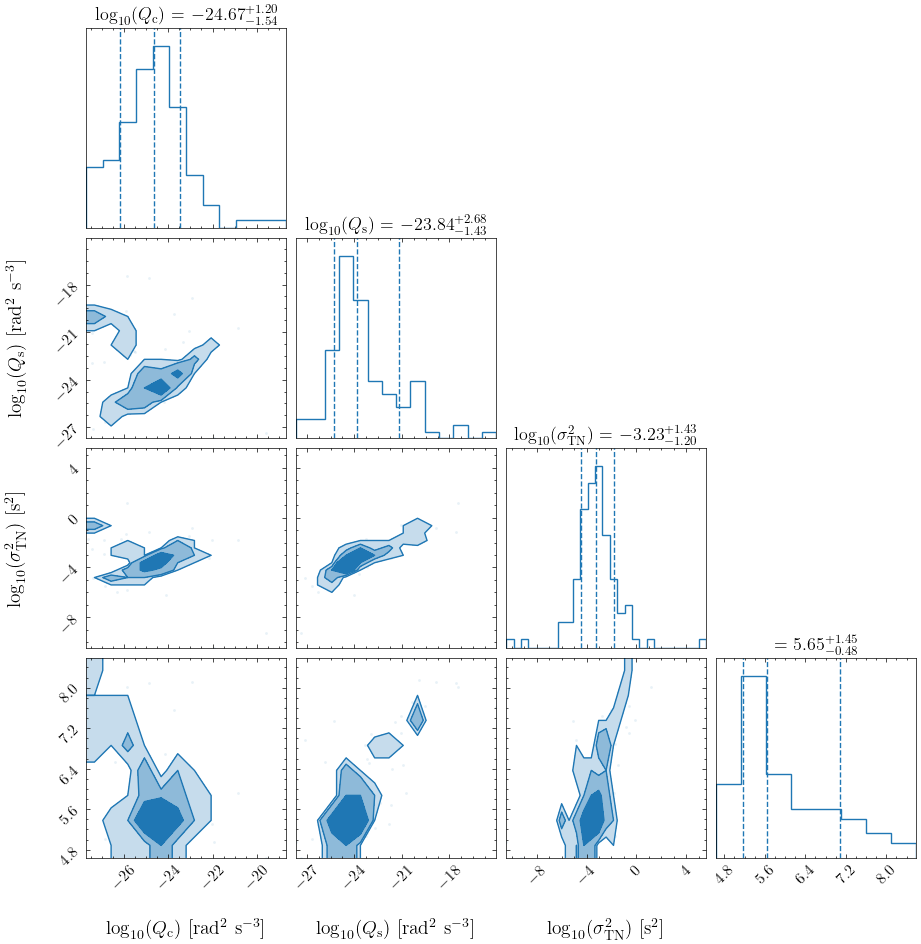

In [17]:
from corner import corner, hist2d

Qc_nbins = calculate_auto_bin_sizes([df_lnBF5["logQc_med"]])
Qs_nbins = calculate_auto_bin_sizes([df_lnBF5["logQs_med"]])
TN_nbins = calculate_auto_bin_sizes([df_lnBF5["logTN_med"]])
tau_nbins = calculate_auto_bin_sizes([df_lnBF5["logtau_med"]])
fig2: plt.Figure = corner(
    df_lnBF5.select(
        pl.col("logQc_med", "logQs_med", "logTN_med"),
        # 2
        # * pl.col("logtau_med")
        # .add(-2 * pl.col("logtaueff_med") - 2 * pl.col("omgc_0").log10())
        # .add(3 * np.log10(pl.col("Tobs").mul(86400)))
        # .add(pl.col("logQc_med")),
        pl.col("logtau_med"),
    ),
    bins=[Qc_nbins[0], Qs_nbins[0], TN_nbins[0], tau_nbins[0]],
    labels=[
        "$\\log_{10}(Q_{\\rm c})$ [rad$^2$ s$^{-3}$]",
        "$\\log_{10}(Q_{\\rm s})$ [rad$^2$ s$^{-3}$]",
        "$\\log_{10}(\sigma_{\\rm TN}^2)$ [s$^2$]",
        "",
    ],
    titles=[
        "$\\log_{10}(Q_{\\rm c})$",
        "$\\log_{10}(Q_{\\rm s})$",
        "$\\log_{10}(\sigma_{\\rm TN}^2)$",
        "",
    ],
    label_kwargs={"fontsize": 14},
    levels=[
        1 - np.exp(-0.5),
        1 - np.exp(-(1.5**2) / 2),
        1 - np.exp(-2),
    ],  # 1σ, 1.5σ, 2σ
    quantiles=[0.16, 0.5, 0.84],
    color="tab:blue",
    show_titles=True,
    title_kwargs={"fontsize": 13},
    # smooth=0.5,
    fill_contours=True,
)
for ax in fig2.get_axes():
    ax.tick_params(axis="both", labelsize=11)

Prepare plots presented in the paper

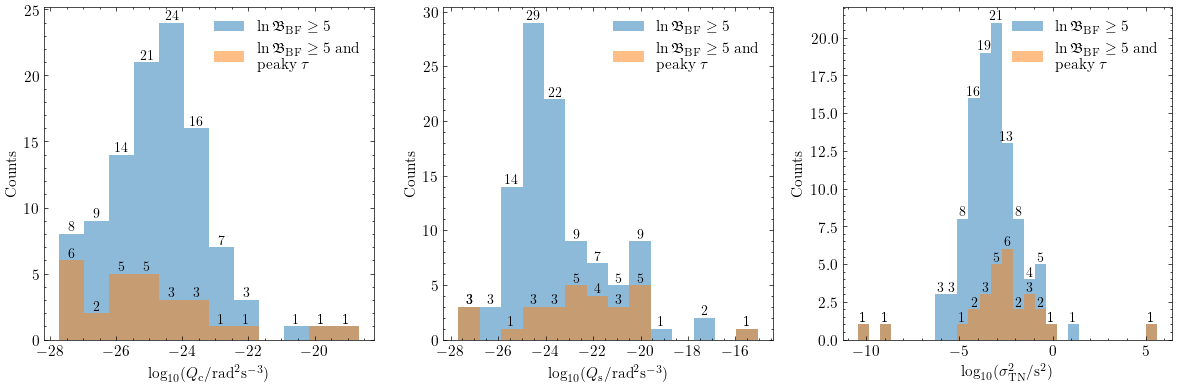

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4.1))

plot_params = [
    ("logQc_med", r"$\log_{10}(Q_{\rm c} / \rm{rad}^2 \rm{s}^{-3})$"),
    ("logQs_med", r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$"),
    ("logTN_med", r"$\log_{10}(\sigma_{\rm TN}^2 / \rm{s}^{2})$"),
]
for ax_i, (col, xlabel) in enumerate(plot_params):
    data = [df_lnBF5[col], df_lnBF5_pkytau[col]]
    nbins = calculate_auto_bin_sizes(data)
    for data_i, d in enumerate(data):
        plot_medians_hist(
            d,
            axs[ax_i],
            bins=nbins[0],  # use the nbins for the first dataset
            xlabel=xlabel,
            label=[
                "$\ln\mathfrak{B}_{\\rm BF} \geq 5$",
                "$\ln\mathfrak{B}_{\\rm BF} \geq 5$ and \n peaky $\\tau$",
            ][data_i],
            show_title=False,
            display_counts=True,
            color=["tab:blue", "tab:orange"][data_i],
            counts_colors=["black", "black"][data_i],
        )

plt.tight_layout()
if SAVE_PLT_TBL:
    plt.savefig(
        "../docs/paperplots/lnBF5_QcQsTN_canonical_hists.pdf",
        # "../docs/paperplots/lnBF5_QcQsTN_canonical_hists.png",
        # dpi=300,
        bbox_inches="tight",
    )

Another version with extra 2D histograms overlaid with scatter points to illustrate correlations. To be put together with 1D histograms in the paper.

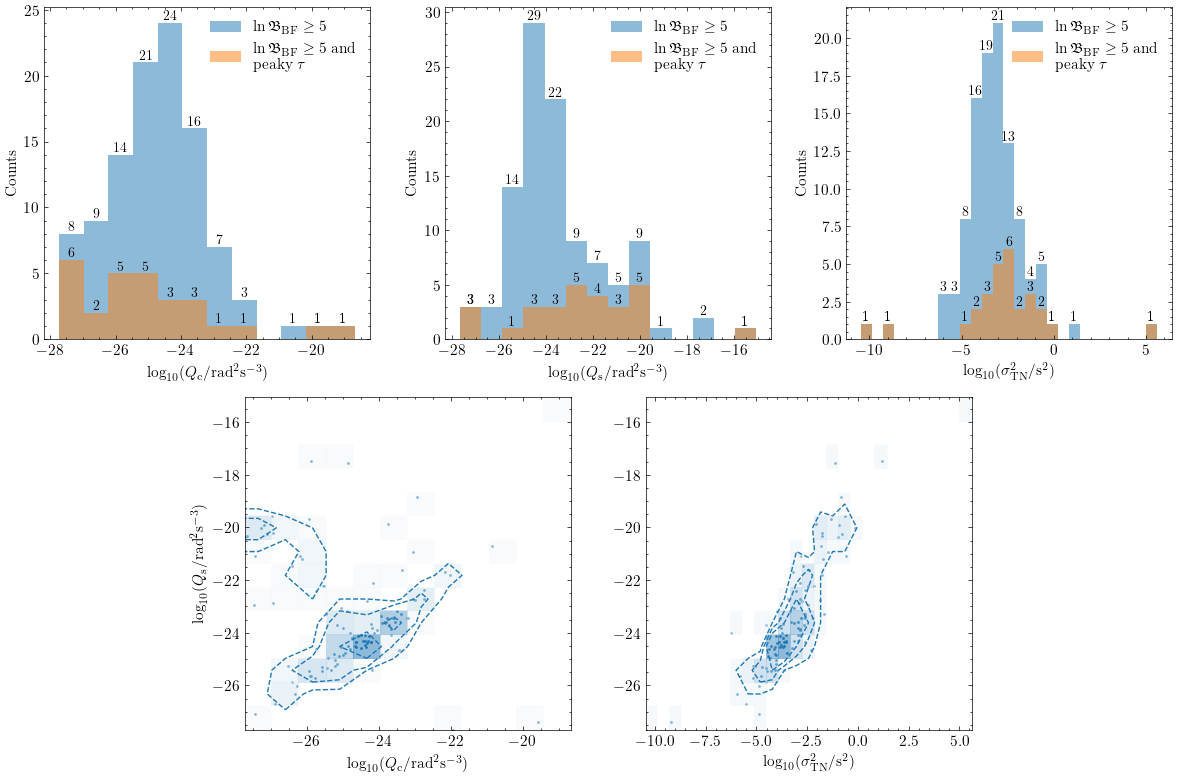

In [19]:
fig_gs = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 6, figure=fig_gs, height_ratios=[1, 1])
axs_gs = [
    [
        fig_gs.add_subplot(gs[0, 0:2]),
        fig_gs.add_subplot(gs[0, 2:4]),
        fig_gs.add_subplot(gs[0, 4:6]),
    ],
    [
        fig_gs.add_subplot(gs[1, 1:3]),
        fig_gs.add_subplot(gs[1, 3:5]),
    ],
]

# 1D marginal distributions
plot_params = [
    ("logQc_med", r"$\log_{10}(Q_{\rm c} / \rm{rad}^2 \rm{s}^{-3})$"),
    ("logQs_med", r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$"),
    ("logTN_med", r"$\log_{10}(\sigma_{\rm TN}^2 / \rm{s}^{2})$"),
]
for ax_i, (col, xlabel) in enumerate(plot_params):
    data = [df_lnBF5[col], df_lnBF5_pkytau[col]]
    nbins = calculate_auto_bin_sizes(data)
    for data_i, d in enumerate(data):
        plot_medians_hist(
            d,
            axs_gs[0][ax_i],
            bins=nbins[0],  # use the nbins for the first dataset
            xlabel=xlabel,
            label=[
                "$\ln\mathfrak{B}_{\\rm BF} \geq 5$",
                "$\ln\mathfrak{B}_{\\rm BF} \geq 5$ and \n peaky $\\tau$",
            ][data_i],
            show_title=False,
            display_counts=True,
            color=["tab:blue", "tab:orange"][data_i],
            counts_colors=["black", "black"][data_i],
        )

# 2D marginal distributions
plot_param_combos = [
    (
        ("logQc_med", r"$\log_{10}(Q_{\rm c} / \rm{rad}^2 \rm{s}^{-3})$"),
        ("logQs_med", r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$"),
    ),
    (
        ("logTN_med", r"$\log_{10}(\sigma_{\rm TN}^2 / \rm{s}^{2})$"),
        ("logQs_med", r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$"),
    ),
]
for ax_i, ((col1, xlabel), (col2, ylabel)) in enumerate(plot_param_combos):
    data = [df_lnBF5[col1], df_lnBF5[col2]]
    nbins = calculate_auto_bin_sizes(data)
    axi: plt.Axes = axs_gs[1][ax_i]
    hist2d(
        df_lnBF5.select(pl.col(col1)).to_numpy(),
        df_lnBF5.select(pl.col(col2)).to_numpy(),
        bins=nbins,
        ax=axi,
        color="tab:blue",
        levels=[
            1 - np.exp(-0.5),
            1 - np.exp(-(1.5**2) / 2),
            1 - np.exp(-2),
        ],  # 1σ, 1.5σ, 2σ
        no_fill_contours=True,
        plot_datapoints=True,
        # plot_density=False,
        # plot_contours=False,
        data_kwargs={"color": "tab:blue", "alpha": 1},
        contour_kwargs={"linestyles": "--"},
        pcolor_kwargs={"alpha": 0.5},
    )
    axi.set_xlabel(xlabel)
    axi.set_ylabel(ylabel)
axs_gs[1][1].sharey(axs_gs[1][0])
axs_gs[1][1].set_ylabel("")

plt.tight_layout()
if SAVE_PLT_TBL:
    plt.savefig(
        "../docs/paperplots/lnBF5_QcQsTN_canonical_hists+2D.pdf",
        # "../docs/paperplots/lnBF5_QcQsTN_canonical_hists+2D.png",
        # dpi=300,
        bbox_inches="tight",
    )

Trailing pulsars in orange histograms

In [20]:
print(
    f"Trailing objects in the left panel: {df_lnBF5_pkytau.filter(pl.col('logQc_med') > -21)['PSRJ'].to_list()}"
)
print(
    f"Trailing objects in the middle panel: {df_lnBF5_pkytau.filter((pl.col('logQs_med') > -18) | (pl.col('logQs_med') < -26))['PSRJ'].to_list()}"
)
print(
    f"Trailing objects in the right panel: {df_lnBF5_pkytau.filter((pl.col('logTN_med') > 0) | (pl.col('logTN_med') < -5))['PSRJ'].to_list()}"
)

Trailing objects in the left panel: ['J1622-4950', 'J2241-5236']
Trailing objects in the middle panel: ['J0437-4715', 'J1622-4950', 'J1849-0636', 'J2241-5236']
Trailing objects in the right panel: ['J0437-4715', 'J1622-4950', 'J2241-5236']


Do a plot with kernel density estimation and double-check the bimodality. Bandwidth is selected with cross-validated bandwidth selection methods in `statsmodels`

dip-stats, p-value for the dip test on logTN_med: (0.03641858719639207, 0.4016)
dip-stats, p-value for the dip test on logQs_med: (0.02256698018167069, 0.9888)
dip-stats, p-value for the dip test on logQc_med: (0.019117502801165254, 0.9997)


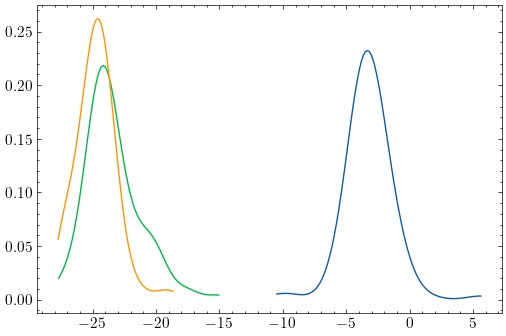

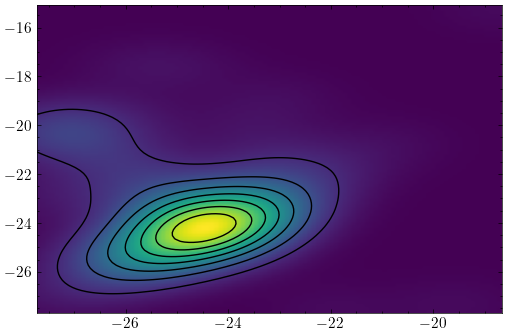

In [21]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate

plt.figure(figsize=(6, 4))
for col in ["logTN_med", "logQs_med", "logQc_med"]:
    print(
        f"dip-stats, p-value for the dip test on {col}: {diptest.diptest(df_lnBF5[col].to_numpy(), boot_pval=True)}"
    )
    x = np.linspace(df_lnBF5[col].min(), df_lnBF5[col].max(), df_lnBF5[col].shape[0])
    plt.plot(x, KDEMultivariate(df_lnBF5[col], var_type="c", bw="cv_ml").pdf(x))

plt.figure(figsize=(6, 4))
for col in [("logQs_med", "logQc_med")]:
    col_y, col_x = col
    x = np.linspace(
        df_lnBF5[col_x].min(), df_lnBF5[col_x].max(), df_lnBF5[col_x].shape[0]
    )
    y = np.linspace(
        df_lnBF5[col_y].min(), df_lnBF5[col_y].max(), df_lnBF5[col_y].shape[0]
    )
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_lnBF5[col_x], df_lnBF5[col_y]])
    kernel = KDEMultivariate(values.T, var_type="cc", bw="cv_ml")
    Z = np.reshape(kernel.pdf(positions), X.shape)
    plt.imshow(
        np.rot90(Z.T),
        cmap=plt.cm.viridis,
        extent=[x.min(), x.max(), y.min(), y.max()],
        aspect="auto",
    )
    plt.contour(X, Y, Z, colors="k")

Venn diagram of peaky $\tau$, peaky $Q_{\rm c}$, and peaky $Q_{\rm s}$.

/Users/Eric.Dong/anaconda3/envs/psrtim/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


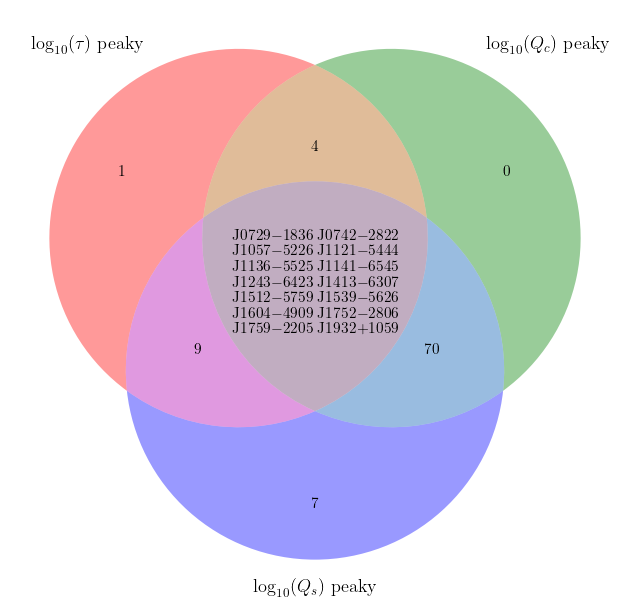

In [22]:
from matplotlib_venn import venn3, venn3_unweighted
from itertools import zip_longest

plt.figure(figsize=(8, 8))
vn = venn3_unweighted(
    subsets=[
        settau := set(df_lnBF5.filter(pl.col("log_tau-dist") == "pky")["PSRJ"]),
        setQc := set(df_lnBF5.filter(pl.col("log_Qc-dist") == "pky")["PSRJ"]),
        setQs := set(df_lnBF5.filter(pl.col("log_Qs-dist") == "pky")["PSRJ"]),
    ],
    set_labels=[
        r"$\log_{10}(\tau)$ peaky",
        r"$\log_{10}(Q_c)$ peaky",
        r"$\log_{10}(Q_s)$ peaky",
    ],
)
# Define all 7 regions of a 3-set Venn diagram
regions = {
    # "100": settau - setQc - setQs,
    # "010": setQc - settau - setQs,
    # "001": setQs - settau - setQc,
    # "110": settau & setQc - setQs,
    # "101": settau & setQs - setQc,
    ## "011": setQc & setQs - settau,
    "111": settau & setQc & setQs,
}
## Label each region with the actual object names except for the largest set
# sorted_region_keys = sorted(regions, key=lambda k: len(regions[k]))
# ignored_regions = sorted_region_keys[-1:]
# regions = {k: v for k, v in regions.items() if k not in ignored_regions}
for region_code, objects in regions.items():
    label = vn.get_label_by_id(region_code)
    if label is None:
        continue
    objects_sorted = sorted(objects)
    if len(objects) <= 5:
        one_column = "\n".join(str(obj) for obj in objects_sorted)
        if region_code == "101":
            one_column = "\n".join(str(obj) + " " * 7 for obj in objects_sorted)
        label.set_text(one_column)
    else:
        left_column = [str(obj) for i, obj in enumerate(objects_sorted) if i % 2 == 0]
        right_column = [str(obj) for i, obj in enumerate(objects_sorted) if i % 2 == 1]
        two_columns = [
            f"{left}  {right}".replace("  None", "").replace("-", "$-$")
            for left, right in zip_longest(left_column, right_column)
        ]
        # two_columns += [""]
        label.set_text("\n".join(two_columns))

if SAVE_PLT_TBL:
    plt.savefig(
        "../docs/paperplots/lnBF5_peaky_tau_Qc_Qs_venn.pdf",
        # "../docs/paperplots/lnBF5_peaky_tau_Qc_Qs_venn.png",
        # dpi=300,
        bbox_inches="tight",
    )

## Post-reweight

some setup

In [23]:
CONFIG_SECT = "analysis3.QcQstau"
exclude_msp = exclude_mag = True
USE_MODEL = "PL_CorrAgnst_Omgc_Omgcdot"

In [24]:
import configparser
import timkf.hyper_run as hpr


def setup_from_config(config_file, config_sect, exclude_msp=False, exclude_mag=False):
    # Load configuration
    config = configparser.ConfigParser(
        allow_no_value=True, interpolation=configparser.ExtendedInterpolation()
    )
    config.read(config_file)

    outdir_parnt = config[config_sect]["outdir_parnt"]
    # Modify the path to the output directory to be relative to the current directory if it exists
    if not os.path.exists(outdir_parnt):
        if os.path.exists(os.path.join("..", outdir_parnt)):
            config[config_sect]["outdir_parnt"] = os.path.join("..", outdir_parnt)
        else:
            raise FileNotFoundError(
                "The output directory does not exist in the current directory or the parent directory"
            )

    # Construct hierarchical model dictionary
    hpp_dict = hpr.construct_hpp_dict_from_config_section(config, config_sect)

    # Get Bayes factor dataframes, with ln(BF) threshold applied
    lnBF_dfs = hpr.get_lnBF_dfs(
        hpp_dict,
        BF_threshold=config[config_sect].getfloat("lnBF_thres"),
        exclude_msp=exclude_msp,
        exclude_mag=exclude_mag,
        exclude_psrs=df_gl_during_with_lnBF5["PSRJ"].to_list(),
    )

    for hpmodel in hpp_dict.keys():
        hpp_dict[hpmodel].categorical_info = hpr.get_category_info(
            lnBF_dfs[hpmodel], hpmodel
        )
        hpp_dict[hpmodel].Tobs_info = hpr.get_Tobs_info(lnBF_dfs[hpmodel], hpmodel)

    return hpp_dict, lnBF_dfs


hpp_dict, lnBF_dfs = setup_from_config(
    "../configs/hyper_config.ini",
    CONFIG_SECT,
    exclude_msp=exclude_msp,
    exclude_mag=exclude_mag,
)

19/10/2025 20:09:52 dict_items([('PL_CorrAgnst_Omgc_Omgcdot', <timkf.hyper.hierarchical_lib.HierarchicalPsrPop object at 0x3128435d0>)])


19/10/2025 20:09:52 Using pulsars with lnBF > 5.0
19/10/2025 20:09:52 Index(['J0401-7608', 'J0452-1759', 'J0627+0706', 'J0659+1414', 'J0729-1836',
       'J0738-4042', 'J0742-2822', 'J0758-1528', 'J0809-4753', 'J0837-4135',
       ...
       'J1903-0632', 'J1909+0007', 'J1909+1102', 'J1913-0440', 'J1916+0951',
       'J1916+1312', 'J1917+1353', 'J1932+1059', 'J1935+1616', 'J2116+1414'],
      dtype='object', name='PSRJ', length=101)


In [25]:
from timkf.hyper.hierarchical_lib import HrchyPopReweightedPosterior

hpmodel_psrs = list(lnBF_dfs[USE_MODEL].index)
tag = hpr.gen_tag(
    hpp_dict[USE_MODEL],
    lnBF_dfs[USE_MODEL],
    sampler=hpp_dict[USE_MODEL].sampler,
    exclude_msp=exclude_msp,
    exclude_mag=exclude_mag,
)

hprp = HrchyPopReweightedPosterior(
    hpp_dict[USE_MODEL],
    hpp_tag=tag,
    reweigh_psrs=hpmodel_psrs,
)

Loading results as generator


Streaming pulsar results: 101it [00:13,  7.63it/s]


In [26]:
import pandas as pd
from timkf.misc import gen_load_bilby_results, timing_noise_strength
from timkf.constants import DAY_TO_SECONDS

reweigh_dict = {
    "PSRJ": [],
    "ratio_reweigh_med": [],
    "ratio_reweigh_68err": [],
    "tau_reweigh_med": [],
    "tau_reweigh_68err": [],
    "Qc_reweigh_med": [],
    "Qc_reweigh_68err": [],
    "Qs_reweigh_med": [],
    "Qs_reweigh_68err": [],
    "TN_reweigh_med": [],
    "TN_reweigh_68err": [],
    "heal_reweigh_med": [],
    "heal_reweigh_68err": [],
}


def healing_parameter(
    taus_over_tauc: pl.Series,
):
    return 1 / (1 + taus_over_tauc ** (-1))


def extract_68_errors(col: pl.Series):
    """Extract 68% credible interval errors from a polar DataFrame column."""
    med = col.median()
    return (col.quantile(0.16) - med, col.quantile(0.84) - med)


for psr, bilby_result in gen_load_bilby_results(
    hprp.hrchy_pop.filtered_data_path_parnt, restrict_to=hpmodel_psrs
):
    wts = hprp.weights.get(psr)
    assert wts is not None, f"Missing weights for {psr}"
    posteriors: pd.DataFrame = bilby_result.posterior.copy()
    posteriors = posteriors.sample(
        # n=len(posteriors),
        n=5000,
        replace=True,
        weights=wts / np.sum(wts),
        random_state=1,
    )
    reweigh_dict["PSRJ"].append(psr)
    for param in ["ratio", "tau", "Qc", "Qs"]:
        reweigh_dict[f"{param}_reweigh_med"].append(
            posteriors[param].apply(np.log10).median()
        )
        reweigh_dict[f"{param}_reweigh_68err"].append(
            extract_68_errors(posteriors[param].apply(np.log10))
        )
    tn_strength = timing_noise_strength(
        posteriors["omgc_0"],
        posteriors["Qc"],
        posteriors["Qs"],
        posteriors["tau"],
        posteriors["ratio"],
        df_PE.filter(pl.col("PSRJ") == psr)["Tobs"].to_numpy()[0] * DAY_TO_SECONDS,
        df_PE.filter(pl.col("PSRJ") == psr)["NTOAs"].to_numpy()[0],
        return_log10=True,
    )
    reweigh_dict["TN_reweigh_med"].append(tn_strength.median())
    reweigh_dict["TN_reweigh_68err"].append(extract_68_errors(tn_strength))
    heal = healing_parameter(posteriors["ratio"])
    reweigh_dict["heal_reweigh_med"].append(heal.apply(np.log10).median())
    reweigh_dict["heal_reweigh_68err"].append(extract_68_errors(heal.apply(np.log10)))

Loading results as generator


Streaming pulsar results: 101it [00:14,  7.05it/s]


Calculate the effective sample sizes for pulsars that undergo reweighting.

J1741-3927
[np.float64(6.676663703106392), np.float64(63.46182030799175), np.float64(75.77348074958442), np.float64(101.32200988497074), np.float64(104.94547862279018)]


Text(0.5, 1.0, 'Distribution of effective sample sizes for reweighted pulsars')

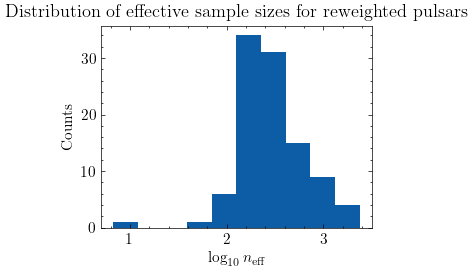

In [27]:
ess = hprp.get_effective_sample_sizes()
print(list(ess.keys())[np.array(list(ess.values())).argmin()])
ess_sort = sorted(np.array(list(ess.values())))
print(ess_sort[:5])
plt.hist(np.log10(ess_sort))
plt.xlabel(r"$\log_{10} n_{\text{eff}}$")
plt.ylabel("Counts")
plt.title("Distribution of effective sample sizes for reweighted pulsars")

Number of logQs median > logQc median: 100


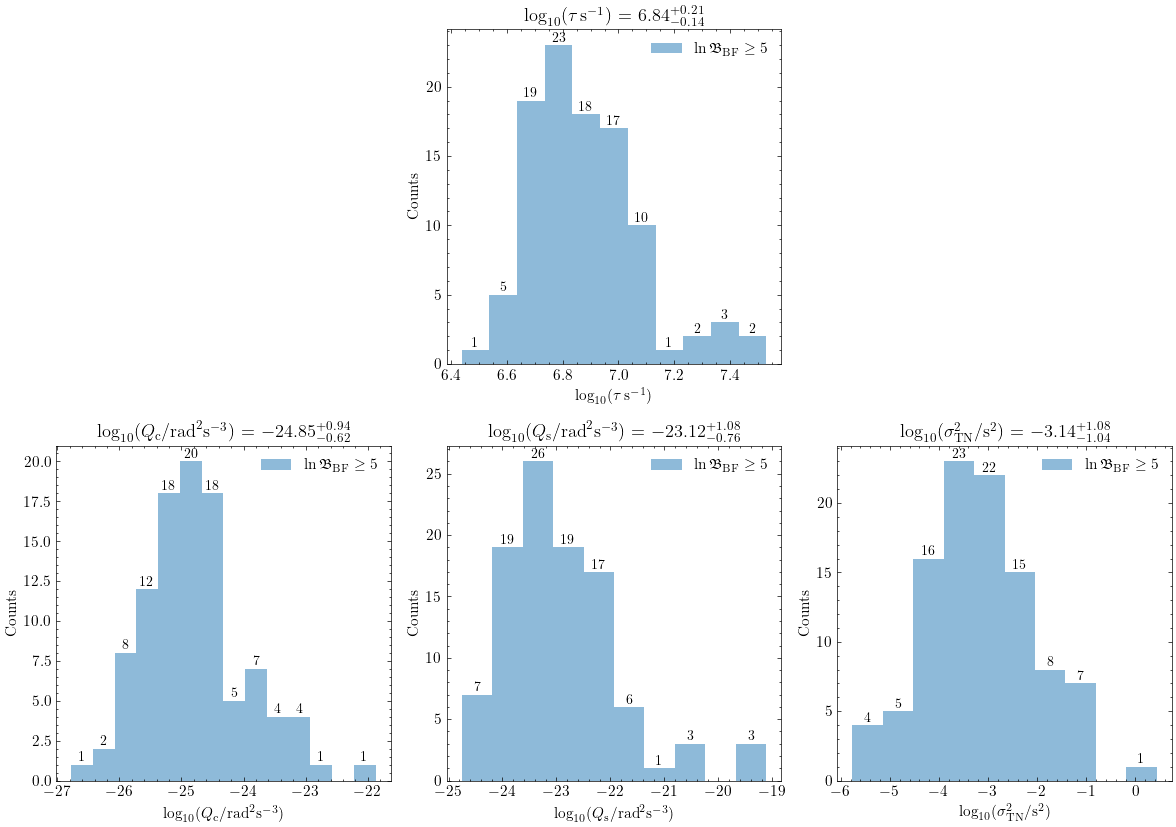

In [28]:
reweigh_df = pl.DataFrame(reweigh_dict)
reweigh_lnBF5_pky = reweigh_df.filter(pl.col("PSRJ").is_in(df_lnBF5_pkytau["PSRJ"]))
reweigh_lnBF5_rr = reweigh_df.filter(pl.col("PSRJ").is_in(df_lnBF5_rrtau["PSRJ"]))
fig, axs = plt.subplots(2, 3, figsize=(12, 8.5))

# tau
for i, d in enumerate(
    [[reweigh_df["tau_reweigh_med"], reweigh_lnBF5_pky["tau_reweigh_med"]][0]]
):
    plot_medians_hist(
        d,
        axs[0, 1],
        xlabel=r"$\log_{10}(\tau\,\rm{s}^{-1})$",
        label=[
            "$\ln\mathfrak{B}_{\\rm BF} \geq 5$",
            "$\ln\mathfrak{B}_{\\rm BF} \geq 5$ and peaky $\\tau$",
        ][i],
        show_title=True,
        color=["tab:blue", "tab:orange"][i],
        counts_colors=["blue", "orange"][i],
    )
axs[0, 0].set_visible(False)
axs[0, 2].set_visible(False)

plot_params = [
    ("Qc_reweigh_med", r"$\log_{10}(Q_{\rm c} / \rm{rad}^2 \rm{s}^{-3})$"),
    ("Qs_reweigh_med", r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$"),
    ("TN_reweigh_med", r"$\log_{10}(\sigma_{\rm TN}^2 / \rm{s}^{2})$"),
]

for ax_i, (col, xlabel) in enumerate(plot_params):
    data = [[reweigh_df[col], reweigh_lnBF5_pky[col]][0]]
    for data_i, d in enumerate(data):
        plot_medians_hist(
            d,
            axs[1, ax_i],
            xlabel=xlabel,
            label=[
                "$\ln\mathfrak{B}_{\\rm BF} \geq 5$",
                "$\ln\mathfrak{B}_{\\rm BF} \geq 5$ and peaky $\\tau$",
            ][data_i],
            show_title=True,
            display_counts=True,
            color=["tab:blue", "tab:orange"][data_i],
            counts_colors=["blue", "orange"][data_i],
        )

plt.tight_layout()

print(
    f"Number of logQs median > logQc median: {np.sum(reweigh_df['Qs_reweigh_med'].to_numpy() >= reweigh_df['Qc_reweigh_med'].to_numpy())}"
)

if SAVE_PLT_TBL:
    plt.savefig(
        "../docs/paperplots/lnBF5_QcQsTN_canonical_hists_postreweight.pdf",
        # "../docs/paperplots/lnBF5_QcQsTN_canonical_hists_postreweight.png",
        # dpi=300,
        bbox_inches="tight",
    )

Scatter plots of uninformed v.s. reweighted estimates for all $\tau$, $Q_{\rm c}$, and $Q_{\rm s}$.

In [29]:
def set_equal_axes(ax, plot_diag=True, aspect="equal"):
    """Set equal axes for a scatter plot."""
    ax.set_aspect(aspect, adjustable="box")
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lim = (
        (np.min([xmin, ymin]), np.max([xmax, ymax]))
        if aspect == "equal"
        else (ymin, ymax)
    )
    if plot_diag:
        ## dashed line for y=x
        ax.plot(lim, lim, color="gray", linestyle="--")


def intersects(x, y, xerr, yerr, m, b):
    xerr_low = xerr[0, :] if isinstance(xerr, np.ndarray) else xerr
    xerr_upp = xerr[1, :] if isinstance(xerr, np.ndarray) else xerr
    yerr_low = yerr[0, :] if isinstance(yerr, np.ndarray) else yerr
    yerr_upp = yerr[1, :] if isinstance(yerr, np.ndarray) else yerr

    x_min = x - xerr_low
    x_max = x + xerr_upp
    y_min = y - yerr_low
    y_max = y + yerr_upp
    y_at_xmin = m * x_min + b
    y_at_xmax = m * x_max + b
    x_at_ymin = (y_min - b) / m
    x_at_ymax = (y_max - b) / m

    # If any y-value of the line of x in [x_min, x_max] lies within [y_min, y_max],
    # or if any x-value of the line of y in [y_min, y_max] lies within [x_min, x_max],
    # it intersects
    return (
        ((y_min <= y_at_xmin) & (y_at_xmin <= y_max))
        | ((y_min <= y_at_xmax) & (y_at_xmax <= y_max))
        | ((x_min <= x_at_ymin) & (x_at_ymin <= x_max))
        | ((x_min <= x_at_ymax) & (x_at_ymax <= x_max))
    )  # Covers crossing through the box


marker_props = dict(color="tab:blue", s=10, marker="o", alpha=0.2)
err_props = dict(fmt="o", color="orange", ms=4, alpha=0.5)

df_reweigh_lnBF5_canonical_pkytau = reweigh_df.filter(
    pl.col("PSRJ").is_in(df_canonical_lnBF5_pkytau["PSRJ"])
)

Red cross objects for $\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$: ['J1401-6357']


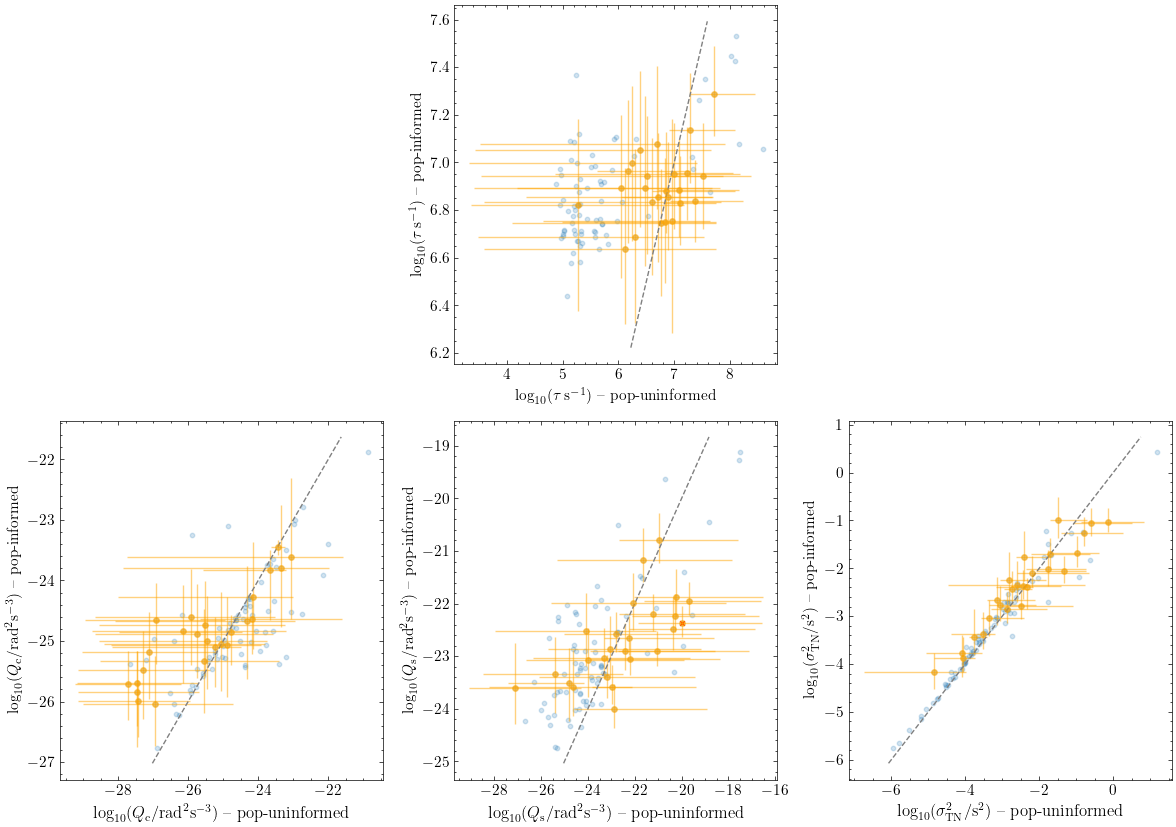

In [30]:
# Scatter plots for lnBF5 canonical pulsars vs reweighted posterior medians
fig, axs = plt.subplots(2, 3, figsize=(12, 8.5))

# tau
axs[0, 0].set_visible(False)
axs[0, 2].set_visible(False)
axs[0, 1].scatter(
    df_canonical_lnBF5["logtau_med"],
    reweigh_df["tau_reweigh_med"],
    **marker_props,
)
axs[0, 1].errorbar(
    df_canonical_lnBF5_pkytau["logtau_med"],
    df_reweigh_lnBF5_canonical_pkytau["tau_reweigh_med"],
    xerr=np.abs(df_canonical_lnBF5_pkytau["logtau_68err"].to_numpy().T),
    yerr=np.abs(np.stack(df_reweigh_lnBF5_canonical_pkytau["tau_reweigh_68err"]).T),
    **err_props,
)
axs[0, 1].set_xlabel(r"$\log_{10}(\tau\,\rm{s}^{-1})$ -- pop-uninformed")
axs[0, 1].set_ylabel(r"$\log_{10}(\tau\,\rm{s}^{-1})$ -- pop-informed")

cols_to_plot = [
    ("logQc_med", "Qc_reweigh_med"),
    ("logQs_med", "Qs_reweigh_med"),
    ("logTN_med", "TN_reweigh_med"),
]
cols_of_err = [
    ("logQc_68err", "Qc_reweigh_68err"),
    ("logQs_68err", "Qs_reweigh_68err"),
    ("logTN_68err", "TN_reweigh_68err"),
]
axes_labels = [
    r"$\log_{10}(Q_{\rm c} / \rm{rad}^2 \rm{s}^{-3})$",
    r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$",
    r"$\log_{10}(\sigma_{\rm TN}^2 / \rm{s}^{2})$",
]
# Qc, Qs, TN
for i, ((col_med, col_reweigh), (col_err, col_reweigh_err), ax_label) in enumerate(
    zip(cols_to_plot, cols_of_err, axes_labels)
):
    axs[1, i].scatter(
        df_canonical_lnBF5[col_med],
        reweigh_df[col_reweigh],
        **marker_props,
    )
    axs[1, i].errorbar(
        df_canonical_lnBF5_pkytau[col_med],
        df_reweigh_lnBF5_canonical_pkytau[col_reweigh],
        xerr=np.abs(df_canonical_lnBF5_pkytau[col_err].to_numpy().T),
        yerr=np.abs(np.stack(df_reweigh_lnBF5_canonical_pkytau[col_reweigh_err]).T),
        **err_props,
    )
    axs[1, i].set_xlabel(ax_label + " -- pop-uninformed", fontsize=12)
    axs[1, i].set_ylabel(ax_label + " -- pop-informed")
    intersect_mask = intersects(
        df_canonical_lnBF5_pkytau[col_med].to_numpy(),
        df_reweigh_lnBF5_canonical_pkytau[col_reweigh].to_numpy(),
        np.abs(df_canonical_lnBF5_pkytau[col_err].to_numpy().T),
        np.abs(np.stack(df_reweigh_lnBF5_canonical_pkytau[col_reweigh_err]).T),
        m=1,
        b=0,
    )
    # non-intersecting points in red
    axs[1, i].scatter(
        df_canonical_lnBF5_pkytau.filter(~intersect_mask)[col_med],
        df_reweigh_lnBF5_canonical_pkytau.filter(~intersect_mask)[col_reweigh],
        color="red",
        s=11,
        marker="x",
    )
    if (~intersect_mask).any():
        print(
            f"Red cross objects for {ax_label}: {df_canonical_lnBF5_pkytau.filter(~intersect_mask)['PSRJ'].to_list()}"
        )

for ax in axs.flatten():
    set_equal_axes(ax, plot_diag=True, aspect="auto")
plt.tight_layout()
if SAVE_PLT_TBL:
    plt.savefig(
        "../docs/paperplots/scatter_tauQcQsTN_lnBF5_canonical_informed-vs-uninformed.pdf",
        # "../docs/paperplots/scatter_tauQcQsTN_lnBF5_canonical_informed-vs-uninformed.png",
        # dpi=300,
        bbox_inches="tight",
    )

Maximum shifts by the population-level information on the per-pulsar posterior medians

In [31]:
for col_orig, col_rwei in zip(
    ["logtau_med", "logQc_med", "logQs_med"],
    ["tau_reweigh_med", "Qc_reweigh_med", "Qs_reweigh_med"],
):
    print(
        f"max(|{col_orig} - {col_rwei}|) = {np.abs(df_canonical_lnBF5[col_orig] - reweigh_df[col_rwei]).max()}"
    )

max(|logtau_med - tau_reweigh_med|) = 2.129707589832867
max(|logQc_med - Qc_reweigh_med|) = 2.6337027537018898
max(|logQs_med - Qs_reweigh_med|) = 3.49707117202378


# of intersections with error bars in x-axis accounted for tau: 24
# of intersections with error bars in y-axis accounted for tau: 10
# of intersections with 2D error boxes accounted for tau: 25

# of intersections with error bars in x-axis accounted for Qc: 22
# of intersections with error bars in y-axis accounted for Qc: 13
# of intersections with 2D error boxes accounted for Qc: 25

# of intersections with error bars in x-axis accounted for Qs: 18
# of intersections with error bars in y-axis accounted for Qs: 7
# of intersections with 2D error boxes accounted for Qs: 24
The following pulsars do not intersect with the line y=x with 2D error boxes for Qs:['J1401-6357']

# of intersections with error bars in x-axis accounted for TN: 24
# of intersections with error bars in y-axis accounted for TN: 16
# of intersections with 2D error boxes accounted for TN: 25



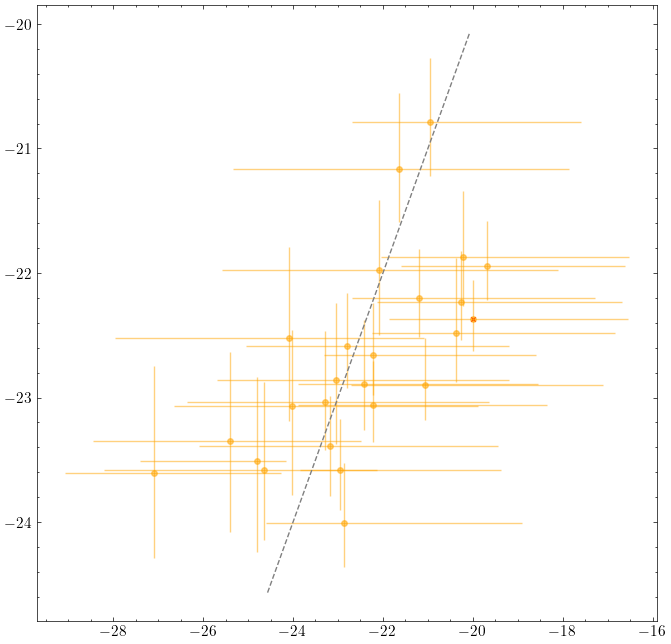

In [32]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.errorbar(
    df_canonical_lnBF5_pkytau["logQs_med"],
    df_reweigh_lnBF5_canonical_pkytau["Qs_reweigh_med"],
    xerr=np.abs(df_canonical_lnBF5_pkytau["logQs_68err"].to_numpy().T),
    yerr=np.abs(np.stack(df_reweigh_lnBF5_canonical_pkytau["Qs_reweigh_68err"]).T),
    **err_props,
)
set_equal_axes(ax, plot_diag=True, aspect="auto")


for par in ["tau", "Qc", "Qs", "TN"]:
    intersect_mask = intersects(
        df_canonical_lnBF5_pkytau[f"log{par}_med"].to_numpy(),
        df_reweigh_lnBF5_canonical_pkytau[f"{par}_reweigh_med"].to_numpy(),
        np.abs(df_canonical_lnBF5_pkytau[f"log{par}_68err"].to_numpy().T),
        0,
        m=1,
        b=0,
    )
    print(
        f"# of intersections with error bars in x-axis accounted for {par}: {intersect_mask.sum()}"
    )
    intersect_mask = intersects(
        df_canonical_lnBF5_pkytau[f"log{par}_med"].to_numpy(),
        df_reweigh_lnBF5_canonical_pkytau[f"{par}_reweigh_med"].to_numpy(),
        0,
        np.abs(np.stack(df_reweigh_lnBF5_canonical_pkytau[f"{par}_reweigh_68err"]).T),
        m=1,
        b=0,
    )
    print(
        f"# of intersections with error bars in y-axis accounted for {par}: {intersect_mask.sum()}"
    )
    intersect_mask = intersects(
        df_canonical_lnBF5_pkytau[f"log{par}_med"].to_numpy(),
        df_reweigh_lnBF5_canonical_pkytau[f"{par}_reweigh_med"].to_numpy(),
        np.abs(df_canonical_lnBF5_pkytau[f"log{par}_68err"].to_numpy().T),
        np.abs(np.stack(df_reweigh_lnBF5_canonical_pkytau[f"{par}_reweigh_68err"]).T),
        m=1,
        b=0,
    )
    print(
        f"# of intersections with 2D error boxes accounted for {par}: {intersect_mask.sum()}"
    )
    if intersect_mask.sum() < 25:
        print(
            f"The following pulsars do not intersect with the line y=x with 2D error boxes for {par}:{df_canonical_lnBF5_pkytau.filter(~intersect_mask)['PSRJ'].to_list()}"
        )
        ax.scatter(
            df_canonical_lnBF5_pkytau.filter(~intersect_mask)[f"log{par}_med"],
            df_reweigh_lnBF5_canonical_pkytau.filter(~intersect_mask)[
                f"{par}_reweigh_med"
            ],
            color="red",
            s=10,
            marker="x",
            label=f"Non-intersecting {par}",
        )
    print("")


Scatter plots of reweighted estimates

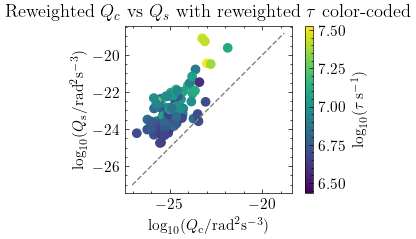

In [33]:
plt.scatter(
    reweigh_df["Qc_reweigh_med"],
    reweigh_df["Qs_reweigh_med"],
    c=reweigh_df["tau_reweigh_med"],
    cmap="viridis",
)
plt.xlabel(r"$\log_{10}(Q_{\rm c} / \rm{rad}^2 \rm{s}^{-3})$")
plt.ylabel(r"$\log_{10}(Q_{\rm s} / \rm{rad}^2 \rm{s}^{-3})$")
plt.colorbar(label=r"$\log_{10}(\tau\,\rm{s}^{-1})$")
plt.title("Reweighted $Q_c$ vs $Q_s$ with reweighted $\\tau$ color-coded")
set_equal_axes(plt.gca(), plot_diag=True)
plt.tight_layout()

kde.factor=np.float64(0.3973156987429393)


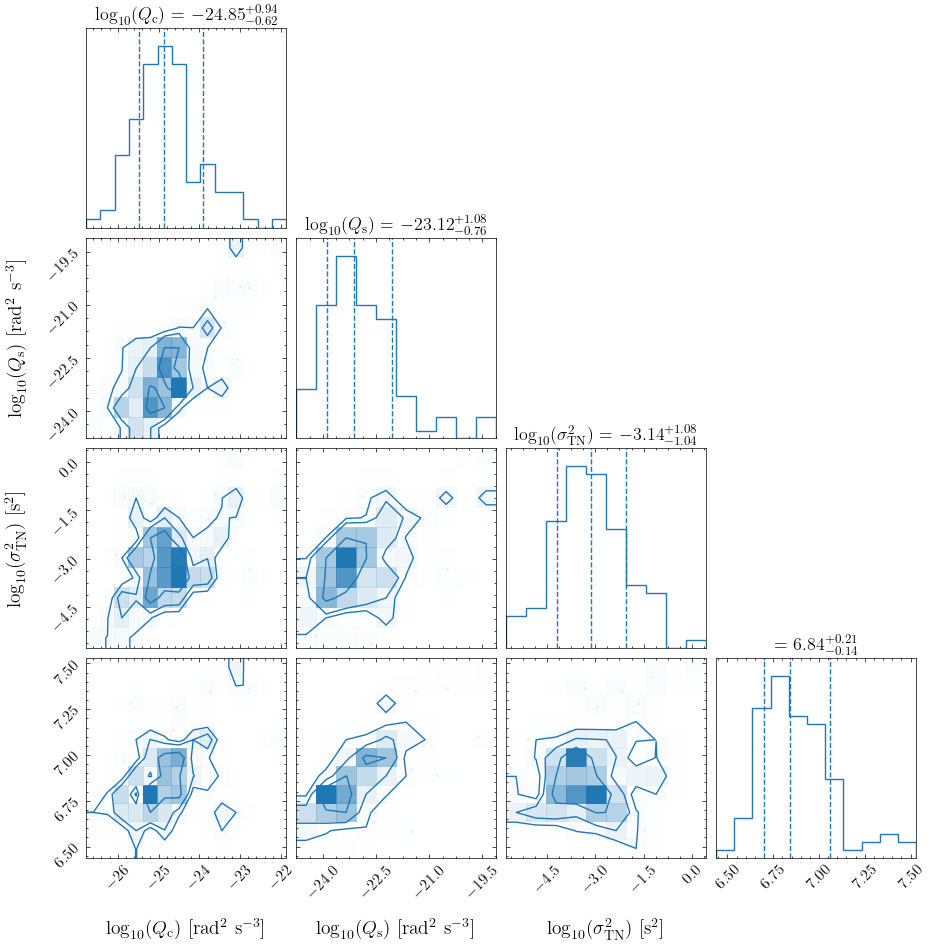

In [34]:
from corner import corner
from scipy.stats import gaussian_kde

# for smooth argument in corner plot
kde = gaussian_kde(reweigh_df["tau_reweigh_med"])
print(f"{kde.factor=}")

Qc_nbins = calculate_auto_bin_sizes([reweigh_df["Qc_reweigh_med"]])
Qs_nbins = calculate_auto_bin_sizes([reweigh_df["Qs_reweigh_med"]])
TN_nbins = calculate_auto_bin_sizes([reweigh_df["TN_reweigh_med"]])
tau_nbins = calculate_auto_bin_sizes([reweigh_df["tau_reweigh_med"]])
fig2 = corner(
    reweigh_df.select(
        pl.col("Qc_reweigh_med", "Qs_reweigh_med", "TN_reweigh_med"),
        pl.col("tau_reweigh_med"),
    ),
    bins=[Qc_nbins[0], Qs_nbins[0], TN_nbins[0], tau_nbins[0]],
    labels=[
        "$\\log_{10}(Q_{\\rm c})$ [rad$^2$ s$^{-3}$]",
        "$\\log_{10}(Q_{\\rm s})$ [rad$^2$ s$^{-3}$]",
        "$\\log_{10}(\sigma_{\\rm TN}^2)$ [s$^2$]",
        "",
    ],
    titles=[
        "$\\log_{10}(Q_{\\rm c})$",
        "$\\log_{10}(Q_{\\rm s})$",
        "$\\log_{10}(\sigma_{\\rm TN}^2)$",
        "",
    ],
    label_kwargs={"fontsize": 14},
    levels=[1 - np.exp(-0.5), 1 - np.exp(-(1.5**2) / 2), 1 - np.exp(-2)],
    quantiles=[0.16, 0.5, 0.84],
    color="tab:blue",
    show_titles=True,
    title_kwargs={"fontsize": 13},
    smooth=kde.factor,
    # fill_contours=True,
    plot_datapoints=True,
)
for ax in fig2.get_axes():
    ax.tick_params(axis="both", labelsize=11)

Comparison of the statistics for the 18 canonical pulsars in the orange histogram in Figure~1 and the 107 population-informed posterior medians in Figure~4.

In [35]:
with pl.Config(set_tbl_cols=30):
    ## uninformed tau
    # print(df_canonical_lnBF5_pkytau["logtau_med"].describe(percentiles=[0.16, 0.5, 0.84]))
    ## informed tau
    # print(reweigh_df["tau_reweigh_med"].describe(percentiles=[0.16, 0.5, 0.84]))
    stat_Qc = df_canonical_lnBF5["logQc_med"].describe(percentiles=[0.16, 0.5, 0.84])[
        "value"
    ]
    stat_Qs = df_canonical_lnBF5["logQs_med"].describe(percentiles=[0.16, 0.5, 0.84])[
        "value"
    ]
    stat_Qc_reweigh = reweigh_df["Qc_reweigh_med"].describe(
        percentiles=[0.16, 0.5, 0.84]
    )["value"]
    stat_Qs_reweigh = reweigh_df["Qs_reweigh_med"].describe(
        percentiles=[0.16, 0.5, 0.84]
    )["value"]
    print("Uninformed Qc, Qs 68% CI:")
    print(
        stat_Qc[-2] - stat_Qc[-4],
        stat_Qs[-2] - stat_Qs[-4],
    )
    print("Informed Qc, Qs 68% CI:")
    print(
        stat_Qc_reweigh[-2] - stat_Qc_reweigh[-4],
        stat_Qs_reweigh[-2] - stat_Qs_reweigh[-4],
    )

Uninformed Qc, Qs 68% CI:
2.694381569692613 3.9923468512189118
Informed Qc, Qs 68% CI:
1.560633512826815 1.8442980275714085


## Pulsars with glitch histories

UTMOST pulsars with $\ln\mathfrak{B}<5$ that have glitch histories not during UTMOST campaign

In [36]:
utmost_BFl5_had_glitches = df_gl_outside.filter(
    pl.col("PSRJ").is_in(df_PE["PSRJ"]) & ~(pl.col("PSRJ").is_in(df_lnBF5["PSRJ"]))
)

print(utmost_BFl5_had_glitches)
print(utmost_BFl5_had_glitches["PSRJ"].to_list())

shape: (23, 5)
┌────────────┬──────────────┬──────────────┬─────────────────────────────────┬────────────────────┐
│ PSRJ       ┆ TSTART       ┆ TFINISH      ┆ GLEP (MJD) val                  ┆ glep_during_timing │
│ ---        ┆ ---          ┆ ---          ┆ ---                             ┆ ---                │
│ str        ┆ f64          ┆ f64          ┆ list[f64]                       ┆ bool               │
╞════════════╪══════════════╪══════════════╪═════════════════════════════════╪════════════════════╡
│ J0525+1115 ┆ 57291.734274 ┆ 58413.726688 ┆ [56010.4]                       ┆ false              │
│ J0601-0527 ┆ 57183.148698 ┆ 58508.490695 ┆ [51665.2, 54347.0]              ┆ false              │
│ J0846-3533 ┆ 57290.931391 ┆ 58465.724357 ┆ [55679.0]                       ┆ false              │
│ J1123-6259 ┆ 57334.046958 ┆ 58401.0151   ┆ [49705.87]                      ┆ false              │
│ J1141-3322 ┆ 57312.020873 ┆ 58426.949949 ┆ [50521.31]                      ┆ false 

Glitch details of those with $\ln\mathfrak{B}<5$ and have resolved $\tau_{\rm g}$.

In [37]:
df_glitch_data_utmostBFl5 = df_glitch_atnf.filter(
    pl.col("PSRJ").is_in(utmost_BFl5_had_glitches["PSRJ"])
)
print(
    f"Total number of glitches happened for all UTMOST pulsars: {len(df_glitch_data_utmostBFl5)}; Unique PSRJs: {len(df_glitch_data_utmostBFl5['PSRJ'].unique())}",
)
df_glitch_utmostBFl5_validtaug = df_glitch_data_utmostBFl5.filter(
    pl.col("T_d (d)").is_not_null() | pl.col("Q").is_not_null()
)
print(
    f"Unique PSRJs with valid tau: {len(df_glitch_utmostBFl5_validtaug['PSRJ'].unique())}"
)
print(df_glitch_utmostBFl5_validtaug)

Total number of glitches happened for all UTMOST pulsars: 33; Unique PSRJs: 23
Unique PSRJs with valid tau: 4
shape: (6, 8)
┌───────┬────────────┬──────────────┬──────────────┬────────┬─────────────┬──────────┬─────────────┐
│ index ┆ PSRJ       ┆ GLEP (MJD)   ┆ Δν/ν (10-9)  ┆ Δν·/ν· ┆ Q           ┆ T_d (d)  ┆ Reference   │
│ ---   ┆ ---        ┆ ---          ┆ ---          ┆ (10-3) ┆ ---         ┆ ---      ┆ ---         │
│ u32   ┆ str        ┆ str          ┆ str          ┆ ---    ┆ str         ┆ str      ┆ str         │
│       ┆            ┆              ┆              ┆ str    ┆             ┆          ┆             │
╞═══════╪════════════╪══════════════╪══════════════╪════════╪═════════════╪══════════╪═════════════╡
│ 207   ┆ J1123-6259 ┆ 49705.87(1)  ┆ 749.12(12)   ┆ 1.0(4) ┆ 0.0026(1)   ┆ 840(100) ┆ wmp+00      │
│ 418   ┆ J1757-2421 ┆ 55702(6)     ┆ 7802.3(13)   ┆ 67(30) ┆ 0.0003(2)   ┆ 15(10)   ┆ ljd+21      │
│ 419   ┆ J1757-2421 ┆ 55702(6)     ┆ null         ┆ null   ┆ 0.0014

UTMOST pulsars with $\ln\mathfrak{B}>5$ that have glitch histories

In [38]:
utmost_BFg5_had_glitches = df_gl_outside.filter(pl.col("PSRJ").is_in(df_lnBF5["PSRJ"]))[
    "PSRJ"
].to_list()

df_canonical_lnBF5_glitched_reweighted = reweigh_df.filter(
    pl.col("PSRJ").is_in(utmost_BFg5_had_glitches)
)[
    "PSRJ",
    "tau_reweigh_med",
    "tau_reweigh_68err",
    "heal_reweigh_med",
    "heal_reweigh_68err",
    "Qs_reweigh_med",
    "Qc_reweigh_med",
]
df_canonical_lnBF5_glitched_reweighted_pkytau = (
    df_canonical_lnBF5_glitched_reweighted.filter(
        # pl.col("PSRJ").is_in(df_canonical_lnBF5_pkytau["PSRJ"])
        pl.col("PSRJ").is_in(df_canonical_lnBF5["PSRJ"])
    )
)

with pl.Config(float_precision=2):
    print(df_canonical_lnBF5_glitched_reweighted)
    print(df_canonical_lnBF5_glitched_reweighted["PSRJ"].to_list())

shape: (23, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ PSRJ       ┆ tau_reweigh_ ┆ tau_reweigh_ ┆ heal_reweig ┆ heal_reweig ┆ Qs_reweigh_ ┆ Qc_reweigh_ │
│ ---        ┆ med          ┆ 68err        ┆ h_med       ┆ h_68err     ┆ med         ┆ med         │
│ str        ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│            ┆ f64          ┆ list[f64]    ┆ f64         ┆ list[f64]   ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ J0659+1414 ┆ 7.10         ┆ [-0.42,      ┆ -1.24       ┆ [-1.75,     ┆ -21.66      ┆ -24.02      │
│            ┆              ┆ 0.46]        ┆             ┆ 0.84]       ┆             ┆             │
│ J0729-1836 ┆ 6.88         ┆ [-0.18,      ┆ -0.00       ┆ [-0.11,     ┆ -23.04      ┆ -24.99      │
│            ┆              ┆ 0.25]        ┆             ┆ 0.00]       ┆    

##### Remark: 
It seems that five out of seven pulsars at the right tail of population-informed $\tau$ histogram are pulsars that have glitch histories.

In [39]:
print(reweigh_df.filter(pl.col("tau_reweigh_med") > 7.2)["PSRJ"].to_list())
df_canonical_lnBF5_glitched_reweighted.filter(pl.col("tau_reweigh_med") > 7.2)
# df_canonical_lnBF5_glitched_reweighted.filter(pl.col("Qc_reweigh_med") > -24)

['J0908-4913', 'J1048-5832', 'J1359-6038', 'J1600-5044', 'J1644-4559', 'J1803-2137', 'J1833-0827']


PSRJ,tau_reweigh_med,tau_reweigh_68err,heal_reweigh_med,heal_reweigh_68err,Qs_reweigh_med,Qc_reweigh_med
str,f64,list[f64],f64,list[f64],f64,f64
"""J0908-4913""",7.530145,"[-0.454731, 0.333648]",-0.017086,"[-0.307091, 0.016737]",-20.458134,-23.000444
"""J1048-5832""",7.447772,"[-0.228603, 0.258799]",-0.003644,"[-0.063809, 0.003466]",-19.114008,-23.24837
"""J1644-4559""",7.285636,"[-0.17555, 0.203163]",-0.022719,"[-0.293075, 0.02214]",-22.485166,-25.705443
"""J1803-2137""",7.426136,"[-0.378194, 0.392567]",-0.004608,"[-0.098834, 0.004374]",-19.275418,-23.103449
"""J1833-0827""",7.364979,"[-0.590104, 0.46313]",-1.501261,"[-1.780216, 1.225465]",-20.502868,-22.789109


Read in the manually copied `atnf_glitch_table.csv`

In [40]:
df_glitch_data_utmost_BFg5 = df_glitch_atnf.filter(
    pl.col("PSRJ").is_in(utmost_BFg5_had_glitches)
)
print(
    f"Total number of glitches happened for UTMOST pulsars: {len(df_glitch_data_utmost_BFg5)}; Unique PSRJs: {len(df_glitch_data_utmost_BFg5['PSRJ'].unique())}",
)
df_glitch_utmost_BFg5_validtaug = df_glitch_data_utmost_BFg5.filter(
    pl.col("T_d (d)").is_not_null() | pl.col("Q").is_not_null()
)
print(
    f"Unique PSRJs with valid tau: {len(df_glitch_utmost_BFg5_validtaug['PSRJ'].unique())}"
)
print(df_glitch_utmost_BFg5_validtaug)

Total number of glitches happened for UTMOST pulsars: 59; Unique PSRJs: 23
Unique PSRJs with valid tau: 5
shape: (11, 8)
┌───────┬────────────┬─────────────┬─────────────┬─────────┬─────────────┬───────────┬─────────────┐
│ index ┆ PSRJ       ┆ GLEP (MJD)  ┆ Δν/ν (10-9) ┆ Δν·/ν·  ┆ Q           ┆ T_d (d)   ┆ Reference   │
│ ---   ┆ ---        ┆ ---         ┆ ---         ┆ (10-3)  ┆ ---         ┆ ---       ┆ ---         │
│ u32   ┆ str        ┆ str         ┆ str         ┆ ---     ┆ str         ┆ str       ┆ str         │
│       ┆            ┆             ┆             ┆ str     ┆             ┆           ┆             │
╞═══════╪════════════╪═════════════╪═════════════╪═════════╪═════════════╪═══════════╪═════════════╡
│ 184   ┆ J1048-5832 ┆ 49034(9)    ┆ 2995(7)     ┆ 3.7(1)  ┆ 0.026(6)    ┆ 160(43)   ┆ wmp+00      │
│ 185   ┆ J1048-5832 ┆ 50788(3)    ┆ 771(2)      ┆ 4.62(6) ┆ 0.008(3)    ┆ 60(20)    ┆ wmp+00      │
│ 189   ┆ J1048-5832 ┆ 56756(4)    ┆ 2964(3)     ┆ 10(7)   ┆ 0.004(2)  

Convert $Q$ and $T_d (d)$ to $\log Q$ and $\log(T_d / \rm{s})$
- numbers in the brackets are the errors in the last decimal places

In [41]:
DAY_TO_SECONDS = 86400

df_glitch_utmost_BFg5_validtaug = cast_parenthetical_expr_to_valerr(
    df_glitch_utmost_BFg5_validtaug,
    "T_d (d)",
)
df_glitch_utmost_BFg5_validtaug = cast_parenthetical_expr_to_valerr(
    df_glitch_utmost_BFg5_validtaug,
    "Q",
)
## convert days to seconds
df_glitch_utmost_BFg5_validtaug = df_glitch_utmost_BFg5_validtaug.with_columns(
    pl.col("T_d (d) val").mul(DAY_TO_SECONDS).alias("T_d (s) val"),
    pl.col("T_d (d) err").mul(DAY_TO_SECONDS).alias("T_d (s) err"),
)
## convert to log10 scale and combine values and errors and convert to string
df_glitch_utmost_BFg5_validtaug_fmt = format_valerr_to_latex(
    df_glitch_utmost_BFg5_validtaug,
    "T_d (s) val",
    "T_d (s) err",
    "log T_d (s) with error",
    log_scale=True,
    error_sigfigs=2,
)
df_glitch_utmost_BFg5_validtaug_fmt = format_valerr_to_latex(
    df_glitch_utmost_BFg5_validtaug_fmt,
    "Q val",
    "Q err",
    "log Q with error",
    log_scale=True,
    error_sigfigs=2,
)

Convert to pandas and hence to latex. Follow the column naming convention in the paper.

In [42]:
## prepare the reweighed values for the glitched pulsars for the latex table
temp_df = df_canonical_lnBF5_glitched_reweighted.filter(
    pl.col("PSRJ").is_in(df_glitch_utmost_BFg5_validtaug["PSRJ"])
)
temp_df = format_valerr_expr_to_latex(
    temp_df,
    pl.col("tau_reweigh_med"),
    pl.col("tau_reweigh_68err").list.get(1),
    pl.col("tau_reweigh_68err").list.get(0),
    "log tau hrchy with error",
    error_sigfigs=2,
)
temp_df = format_valerr_expr_to_latex(
    temp_df,
    pl.col("heal_reweigh_med"),
    pl.col("heal_reweigh_68err").list.get(1),
    pl.col("heal_reweigh_68err").list.get(0),
    "log heal hrchy with error",
    error_sigfigs=2,
)
## combine our results with the glitched pulsars data
df_glitch_utmost_BFg5_validtaug_joined = df_glitch_utmost_BFg5_validtaug_fmt[
    "PSRJ", "GLEP (MJD)", "log T_d (s) with error", "log Q with error", "Reference"
].join(
    temp_df,
    on="PSRJ",
    how="left",
)
## reorder the columns and drop unnecessary ones
df_glitch_utmost_BFg5_validtaug_joined = (
    df_glitch_utmost_BFg5_validtaug_joined[
        "PSRJ",
        "log tau hrchy with error",
        "log heal hrchy with error",
        "GLEP (MJD)",
        "log T_d (s) with error",
        "log Q with error",
        "Reference",
    ]
    .with_columns(
        pl.col("PSRJ")
        .str.replace("-", "$-$", literal=True)
        .str.replace("J", "", literal=True)
    )
    .fill_null("---")
)
df_glitch_utmost_BFg5_validtaug_joined = (
    df_glitch_utmost_BFg5_validtaug_joined.with_columns(
        pl.col("Reference")
        .str.replace("wmp+00", "\citet{WangEtAl2000}", literal=True)
        .str.replace("ljd+21", "\citet{LowerEtAl2021}", literal=True)
        .str.replace("mks+10", "\citet{ManchesterEtAl2010}", literal=True)
        .str.replace("elsk11", "\citet{EspinozaEtAl2011}", literal=True)
        .str.replace("ymh+13", "\citet{YuEtAl2013}", literal=True)
        .str.replace("lws+22", "\citet{LiuEtAl2022}", literal=True)
        .str.replace("sl96", "")
    )
)

## rename the columns for the latex table
df_glitch_utmost_BFg5_validtaug_joined.columns = [
    "PSR J",
    r"\(\log_{10} (\tau\,\rm{s}^{-1})\)",
    # r"\(\log_{10} (\tau_{\rm s}/\tau_{\rm c})\)",
    r"\(\log_{10} [(1 + \tau_{\rm c}/\tau_{\rm s})^{-1}]\)",
    "Epoch",
    r"\(\log_{10} (\tau_{\rm g}\,\rm{s}^{-1})\)",
    r"\(\log_{10} q_{\rm heal}\)",
    "References",
]
df_glitch_utmost_BFg5_validtaug_joined

PSR J,"\(\log_{10} (\tau\,\rm{s}^{-1})\)",\(\log_{10} [(1 + \tau_{\rm c}/\tau_{\rm s})^{-1}]\),Epoch,"\(\log_{10} (\tau_{\rm g}\,\rm{s}^{-1})\)",\(\log_{10} q_{\rm heal}\),References
str,str,str,str,str,str,str
"""1048$-$5832""","""$7.4^{+0.26}_{-0.23}$""","""$-0.0036^{+0.0035}_{-0.064}$""","""49034(9)""","""$7.1^{+0.1}_{-0.14}$""","""$-1.6^{+0.09}_{-0.11}$""","""\citet{WangEtAl2000}"""
"""1048$-$5832""","""$7.4^{+0.26}_{-0.23}$""","""$-0.0036^{+0.0035}_{-0.064}$""","""50788(3)""","""$6.7^{+0.12}_{-0.18}$""","""$-2.1^{+0.14}_{-0.2}$""","""\citet{WangEtAl2000}"""
"""1048$-$5832""","""$7.4^{+0.26}_{-0.23}$""","""$-0.0036^{+0.0035}_{-0.064}$""","""56756(4)""","""$6.6^{+0.23}_{-0.5}$""","""$-2.4^{+0.18}_{-0.3}$""","""\citet{LowerEtAl2021}"""
"""1141$-$6545""","""$7.0^{+0.3}_{-0.3}$""","""$-0.63^{+0.57}_{-0.81}$""","""54277(20)""","""$7.6^{+0.11}_{-0.14}$""","""$-2.4^{+0.07}_{-0.084}$""","""\citet{ManchesterEtAl2010}"""
"""1452$-$6036""","""$6.9^{+0.26}_{-0.43}$""","""$-0.0037^{+0.0036}_{-0.15}$""","""55055.22(4)""","""$8.3^{+0.12}_{-0.16}$""","""$-0.92^{+0.15}_{-0.23}$""","""\citet{LowerEtAl2021}"""
"""1803$-$2137""","""$7.4^{+0.39}_{-0.38}$""","""$-0.0046^{+0.0044}_{-0.099}$""","""48245(11)""","""$7.1^{+0.0084}_{-0.0085}$""","""$-1.9^{+0.0094}_{-0.0096}$""","""\citet{EspinozaEtAl2011} """
"""1803$-$2137""","""$7.4^{+0.39}_{-0.38}$""","""$-0.0046^{+0.0044}_{-0.099}$""","""50777(4)""","""$6.0^{+0.067}_{-0.079}$""","""$-2.0^{+0.048}_{-0.054}$""","""\citet{EspinozaEtAl2011} \cite…"
"""1803$-$2137""","""$7.4^{+0.39}_{-0.38}$""","""$-0.0046^{+0.0044}_{-0.099}$""","""50777(4)""","""$6.8^{+0.075}_{-0.091}$""","""$-2.5^{+0.19}_{-0.36}$""","""\citet{YuEtAl2013}"""
"""1803$-$2137""","""$7.4^{+0.39}_{-0.38}$""","""$-0.0046^{+0.0044}_{-0.099}$""","""53429(1)""","""$7.1^{+0.035}_{-0.037}$""","""$-2.2^{+0.011}_{-0.011}$""","""\citet{EspinozaEtAl2011} \cite…"


In [ ]:
import re


def apply_multirow(df: pd.DataFrame, col: str, add_hline=False) -> pd.DataFrame:
    df = df.copy()
    groups = df.groupby(col, sort=False)

    multirow_values = []
    for value, group in groups:
        n_rows = len(group)
        for i, _ in enumerate(group.index):
            if i == 0:
                if add_hline:
                    multirow_values.append(
                        f"\\hline \\multirow{{{n_rows}}}{{*}}{{{value}}}"
                    )
                else:
                    multirow_values.append(f"\\multirow{{{n_rows}}}{{*}}{{{value}}}")
            else:
                multirow_values.append("")

    df[col] = multirow_values
    return df


temp_pd = df_glitch_utmost_BFg5_validtaug_joined.to_pandas()
temp_pd = apply_multirow(temp_pd, "PSR J", add_hline=True)
temp_pd = apply_multirow(temp_pd, r"\(\log_{10} (\tau\,\rm{s}^{-1})\)")
# temp_pd = apply_multirow(temp_pd, r"\(\log_{10} (\tau_{\rm s}/\tau_{\rm c})\)")
temp_pd = apply_multirow(
    temp_pd, r"\(\log_{10} [(1 + \tau_{\rm c}/\tau_{\rm s})^{-1}]\)"
)

latex_code = temp_pd.to_latex(
    index=False, multirow=True, column_format="lcccccl", escape=False
)
latex_code = re.sub(
    r"\\(top|mid|bottom)rule",
    r"\\hline",
    latex_code,
)
latex_code = re.sub(
    r"} \\citet{",
    r",",
    latex_code,
)  # combine multiple cites

if SAVE_PLT_TBL:
    with open("../docs/papertabs/glitched_pulsars.tex", "w") as f:
        f.write(latex_code)

Quantitative comparison between $\tau$ and $\tau_{\rm g}$

In [44]:
df_temp = df_glitch_utmost_BFg5_validtaug.join(
    df_canonical_lnBF5_glitched_reweighted.filter(
        pl.col("PSRJ").is_in(df_glitch_utmost_BFg5_validtaug["PSRJ"])
    ),
    on="PSRJ",
    how="left",
).with_columns(
    pl.col("T_d (s) val").log10().alias("log T_d (s) val"),
    pl.col("Q val").log10().alias("log Q val"),
)
df_temp = df_temp.with_columns(
    (
        (pl.col("log T_d (s) val").sub(pl.col("tau_reweigh_med")).abs())
        / pl.col("log T_d (s) val")
    ).alias("log tau rel diff"),
    pl.col("log T_d (s) val").sub(pl.col("tau_reweigh_med")).abs().alias("tau diff"),
)
df_temp.group_by("PSRJ").agg(pl.col("log tau rel diff")).sort("PSRJ")
# df_temp.group_by("PSRJ").agg(pl.col("log T_d (s) val").std())
# df_temp.group_by("PSRJ").agg(pl.col("tau diff").mean())

PSRJ,log tau rel diff
str,list[f64]
"""J1048-5832""","[0.043013, 0.10918, 0.120963]"
"""J1141-6545""",[0.087451]
"""J1452-6036""",[0.168008]
"""J1803-2137""","[0.042406, 0.23446, 0.09605, 0.051806, 0.135742]"
"""J1833-0827""",[0.017608]


## Effect of pre-observation glitch

In [47]:
def residualGL(t, Δν_frac, q_heal, τ_g, glep, tstart):
    tgap = tstart - glep
    tobs = t - tstart
    Δν_frac_decay_at_tstart = Δν_frac * q_heal * np.exp(-tgap / τ_g)

    residual = Δν_frac_decay_at_tstart * (τ_g * (1 - np.exp(-tobs / τ_g)) - tobs)
    return residual, tgap / τ_g

In [48]:
df_glitch_utmost_BFg5_validtaug = cast_parenthetical_expr_to_valerr(
    df_glitch_utmost_BFg5_validtaug, "GLEP (MJD)"
)
df_glitch_utmost_BFg5_validtaug = df_glitch_utmost_BFg5_validtaug.with_columns(
    pl.col("Δν/ν (10-9)").fill_null(strategy="forward")
)
df_glitch_utmost_BFg5_validtaug = cast_parenthetical_expr_to_valerr(
    df_glitch_utmost_BFg5_validtaug, "Δν/ν (10-9)"
)
df_temp = df_glitch_utmost_BFg5_validtaug.join(
    df_gl_outside.filter(pl.col("PSRJ").is_in(df_glitch_utmost_BFg5_validtaug["PSRJ"]))[
        "PSRJ", "TSTART", "TFINISH"
    ],
    on="PSRJ",
).drop("GLEP (MJD)", "Q", "T_d (d)", "Reference", "Δν/ν (10-9)", "Δν·/ν· (10-3)")
## using typical values for first test
# df_temp.with_columns(
#     residualGL(
#         t=pl.col("TFINISH") * DAY_TO_SECONDS,
#         Δν_frac=pl.col("Δν/ν (10-9) val") * 1e-9,
#         q_heal=pl.col("Q val"),
#         τ_g=pl.col("T_d (d) val") * DAY_TO_SECONDS,
#         glep=pl.col("GLEP (MJD) val") * DAY_TO_SECONDS,
#         tstart=pl.col("TSTART") * DAY_TO_SECONDS,
#     ).alias("residual at TFINISH (s)")
# )
# df_temp.join(df_PE["PSRJ", "TN_reweigh_med", "TN_reweigh_68err"], on="PSRJ", how="left")
df_temp = df_temp.join(df_PE["PSRJ", "logTN_med", "logTN_68err"], on="PSRJ", how="left")

In [50]:
n_realizations = int(1e5)
Δν_fracs = (
    np.random.normal(
        df_temp["Δν/ν (10-9) val"].to_numpy(),
        scale=df_temp["Δν/ν (10-9) err"].to_numpy(),
        size=(n_realizations, len(df_temp)),
    )
    * 1e-9
)
Q_vals = np.random.normal(
    df_temp["Q val"].to_numpy(),
    scale=df_temp["Q err"].to_numpy(),
    size=(n_realizations, len(df_temp)),
)
T_d_vals = np.random.normal(
    df_temp["T_d (d) val"].to_numpy(),
    scale=df_temp["T_d (d) err"].to_numpy(),
    size=(n_realizations, len(df_temp)),
)
GLEP_vals = np.random.normal(
    df_temp["GLEP (MJD) val"].to_numpy(),
    scale=df_temp["GLEP (MJD) err"].to_numpy(),
    size=(n_realizations, len(df_temp)),
)
non_neg_mask = (Δν_fracs > 0) & (Q_vals > 0) & (T_d_vals > 0) & (GLEP_vals > 0)
resGLs, tgap_over_tau_g = residualGL(
    t=df_temp["TFINISH"].to_numpy() * DAY_TO_SECONDS,
    Δν_frac=np.where(non_neg_mask, Δν_fracs, np.nan),
    q_heal=np.where(non_neg_mask, Q_vals, np.nan),
    τ_g=np.where(non_neg_mask, T_d_vals * DAY_TO_SECONDS, np.nan),
    glep=np.where(non_neg_mask, GLEP_vals * DAY_TO_SECONDS, np.nan),
    tstart=df_temp["TSTART"].to_numpy() * DAY_TO_SECONDS,
)
# drop rows with any nan
resGLs = resGLs[~np.isnan(resGLs).any(axis=1)]
tgap_over_tau_g = tgap_over_tau_g[~np.isnan(tgap_over_tau_g).any(axis=1)]
# only interested in the magnitude
resGLs = np.abs(resGLs)
df_temp = df_temp.with_columns(
    pl.Series(name="residual at TFINISH (s) median", values=np.median(resGLs, axis=0)),
    pl.Series(
        name="residual at TFINISH (s) 16th perc",
        values=np.quantile(resGLs, 0.16, axis=0),
    ),
    pl.Series(
        name="residual at TFINISH (s) 84th perc",
        values=np.quantile(resGLs, 0.84, axis=0),
    ),
    pl.Series(
        name="tgap/τ_g median", values=np.median(tgap_over_tau_g, axis=0)
    ),
)
# print(df_temp["residual at TFINISH (s) median"] - df_temp["residual at TFINISH (s) 16th perc"])
# print(df_temp["residual at TFINISH (s) 84th perc"] - df_temp["residual at TFINISH (s) median"])
df_temp

index,PSRJ,T_d (d) val,T_d (d) err,Q val,Q err,T_d (s) val,T_d (s) err,GLEP (MJD) val,GLEP (MJD) err,Δν/ν (10-9) val,Δν/ν (10-9) err,TSTART,TFINISH,logTN_med,logTN_68err,residual at TFINISH (s) median,residual at TFINISH (s) 16th perc,residual at TFINISH (s) 84th perc,tgap/τ_g median
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,struct[2],f64,f64,f64,f64
184,"""J1048-5832""",160.0,43.0,0.026,0.006,1.3824e7,3.7152e6,49034.0,9.0,2995.0,7.0,57191.435435,58415.948564,1.191874,"{-0.589295,0.24963}",4.8891e-22,3.5094e-30,2.2399e-17,50.995638
185,"""J1048-5832""",60.0,20.0,0.008,0.003,5.184e6,1.728e6,50788.0,3.0,771.0,2.0,57191.435435,58415.948564,1.191874,"{-0.589295,0.24963}",2.7971e-47,3.6845e-70,8.3417e-36,106.59942
189,"""J1048-5832""",51.0,35.0,0.004,0.002,4.4064e6,3.024e6,56756.0,4.0,2964.0,3.0,57191.435435,58415.948564,1.191874,"{-0.589295,0.24963}",0.000326,1.4470e-8,0.007646,8.026158
210,"""J1141-6545""",495.0,140.0,0.004,0.0007,4.2768e7,1.2096e7,54277.0,20.0,589.0,0.6,57160.388003,58424.955043,-4.073794,"{-0.775268,0.347349}",0.000475,0.000056,0.001529,5.824278
288,"""J1452-6036""",2415.0,747.0,0.12,0.05,2.08656e8,6.45408e7,55055.22,0.04,28.95,0.03,57955.372657,58427.079343,-3.209464,"{-0.315702,0.611788}",0.003606,0.001961,0.005295,1.198739
442,"""J1803-2137""",154.0,3.0,0.0137,0.0003,1.33056e7,259200.0,48245.0,11.0,4074.4,0.3,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",5.9021e-28,1.7277e-28,1.9668e-27,63.106868
444,"""J1803-2137""",12.0,2.0,0.0094,0.0011,1.0368e6,172800.0,50777.0,4.0,3184.0,1.0,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",5.9290e-261,8.3666e-313,8.2930e-224,599.37689
445,"""J1803-2137""",69.0,13.0,0.003,0.0017,5.9616e6,1.1232e6,50777.0,4.0,3184.0,1.0,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",1.5731e-46,5.8440e-57,2.0799e-39,104.181785
446,"""J1803-2137""",133.0,11.0,0.0063,0.00016,1.14912e7,950400.0,53429.0,1.0,3929.3,0.4,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",1.0949e-15,5.2187e-17,1.4224e-14,34.098226


In [270]:
from timkf.misc import find_sorted_subdirs
from bilby import read_in_result

subdirs = find_sorted_subdirs(RESULTS_DIR)
dict_temp = {}
for sd in subdirs:
    _, psrj = sd.split("_")
    if psrj not in df_temp["PSRJ"].to_list():
        continue
    result_json_path = os.path.join(RESULTS_DIR, sd, f"{psrj}_result.json")
    assert os.path.exists(result_json_path), f"{result_json_path} does not exist"
    result_posterior = read_in_result(result_json_path).posterior
    log_TN_strength = timing_noise_strength(
        result_posterior["omgc_0"],
        result_posterior["Qc"],
        result_posterior["Qs"],
        result_posterior["tau"],
        result_posterior["ratio"],
        df_PE.filter(pl.col("PSRJ") == psrj)["Tobs"].to_numpy()[0] * DAY_TO_SECONDS,
        df_PE.filter(pl.col("PSRJ") == psrj)["NTOAs"].to_numpy()[0],
        return_log10=True,
    )
    dict_temp[psrj] = log_TN_strength / 2  # convert log10(sigma^2) to log10(sigma)

In [ ]:
rng = np.random.default_rng(1006)
n_draws = 10000
rng.choice(dict_temp["J1141-6545"], size=n_draws, replace=True)
series_resGL_over_TN = []
for gl_i, psrj in enumerate(df_temp["PSRJ"]):
    log_TN_strength_draws = rng.choice(dict_temp[psrj], size=n_draws, replace=True)
    residual_GL_draws = rng.choice(resGLs[:, gl_i], size=n_draws, replace=True)

    resGL_over_TN = residual_GL_draws / (10**log_TN_strength_draws)

    series_resGL_over_TN.append(resGL_over_TN)

series_resGL_over_TN = np.array(series_resGL_over_TN).T
df_temp = df_temp.with_columns(
    pl.Series(
        name="resGL_over_TN median", values=np.median(series_resGL_over_TN, axis=0)
    ),
    pl.Series(
        name="resGL_over_TN 16th perc",
        values=np.quantile(series_resGL_over_TN, 0.16, axis=0),
    ),
    pl.Series(
        name="resGL_over_TN 84th perc",
        values=np.quantile(series_resGL_over_TN, 0.84, axis=0),
    ),
)
print(np.log10(df_temp["resGL_over_TN median"])[2:5])
print(
    np.log10(df_temp["resGL_over_TN 16th perc"])[2:5]
    - np.log10(df_temp["resGL_over_TN median"])[2:5]
)
print(
    np.log10(df_temp["resGL_over_TN 84th perc"])[2:5]
    - np.log10(df_temp["resGL_over_TN median"])[2:5]
)
df_temp

shape: (3,)
Series: 'resGL_over_TN median' [f64]
[
	-4.062874
	-1.264088
	-0.881308
]
shape: (3,)
Series: 'resGL_over_TN 16th perc' [f64]
[
	-4.545995
	-1.007294
	-0.469094
]
shape: (3,)
Series: 'resGL_over_TN 84th perc' [f64]
[
	1.424399
	0.615123
	0.270307
]


index,PSRJ,T_d (d) val,T_d (d) err,Q val,Q err,T_d (s) val,T_d (s) err,GLEP (MJD) val,GLEP (MJD) err,Δν/ν (10-9) val,Δν/ν (10-9) err,TSTART,TFINISH,logTN_med,logTN_68err,residual at TFINISH (s) median,residual at TFINISH (s) 16th perc,residual at TFINISH (s) 84th perc,resGL_over_TN median,resGL_over_TN 16th perc,resGL_over_TN 84th perc
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,struct[2],f64,f64,f64,f64,f64,f64
184,"""J1048-5832""",160.0,43.0,0.026,0.006,1.3824e7,3.7152e6,49034.0,9.0,2995.0,7.0,57191.435435,58415.948564,1.191874,"{-0.589295,0.24963}",5.6565e-22,4.9789e-30,2.3307e-17,1.5204e-22,1.8225e-30,6.7786e-18
185,"""J1048-5832""",60.0,20.0,0.008,0.003,5.184e6,1.728e6,50788.0,3.0,771.0,2.0,57191.435435,58415.948564,1.191874,"{-0.589295,0.24963}",3.7088e-47,6.5897e-70,9.5438e-36,1.2358e-47,1.3402e-70,2.9862e-36
189,"""J1048-5832""",51.0,35.0,0.004,0.002,4.4064e6,3.024e6,56756.0,4.0,2964.0,3.0,57191.435435,58415.948564,1.191874,"{-0.589295,0.24963}",0.000322,1.1220e-8,0.007445,0.000087,2.4611e-9,0.002299
210,"""J1141-6545""",495.0,140.0,0.004,0.0007,4.2768e7,1.2096e7,54277.0,20.0,589.0,0.6,57160.388003,58424.955043,-4.073794,"{-0.775268,0.347349}",0.000468,0.000054,0.001531,0.054439,0.005353,0.224407
288,"""J1452-6036""",2415.0,747.0,0.12,0.05,2.08656e8,6.45408e7,55055.22,0.04,28.95,0.03,57955.372657,58427.079343,-3.209464,"{-0.315702,0.611788}",0.003609,0.001955,0.005299,0.131429,0.044627,0.244906
442,"""J1803-2137""",154.0,3.0,0.0137,0.0003,1.33056e7,259200.0,48245.0,11.0,4074.4,0.3,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",5.9489e-28,1.7325e-28,1.9571e-27,2.4621e-27,6.3777e-28,9.6488e-27
444,"""J1803-2137""",12.0,2.0,0.0094,0.0011,1.0368e6,172800.0,50777.0,4.0,3184.0,1.0,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",1.5555e-260,1.7247e-312,1.6431e-223,3.0310e-259,2.1938e-311,3.1268e-223
445,"""J1803-2137""",69.0,13.0,0.003,0.0017,5.9616e6,1.1232e6,50777.0,4.0,3184.0,1.0,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",1.8860e-46,6.7653e-57,2.2786e-39,6.3794e-46,2.6035e-56,6.6917e-39
446,"""J1803-2137""",133.0,11.0,0.0063,0.00016,1.14912e7,950400.0,53429.0,1.0,3929.3,0.4,57962.485816,58421.237001,-1.13883,"{-0.796602,0.386373}",1.1034e-15,5.3093e-17,1.4390e-14,4.7712e-15,2.0605e-16,6.5684e-14


# Extra plots that are not included in the paper

#### Reweighted bimodal $\tau$ example: PSR J1141-6545

Processing PSRs: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
/var/folders/0f/w1j_z2b96f53kqjcj06c8yrw0000gn/T/ipykernel_8994/245879003.py:33: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()



Available search_parameter_keys: ['ratio', 'tau', 'Qc', 'Qs', 'lag', 'omgc_dot', 'omgc_0', 'EFAC', 'EQUAD']
Plotted parameters: ['ratio', 'tau', 'Qc', 'Qs']
Re-autoscaling axes...


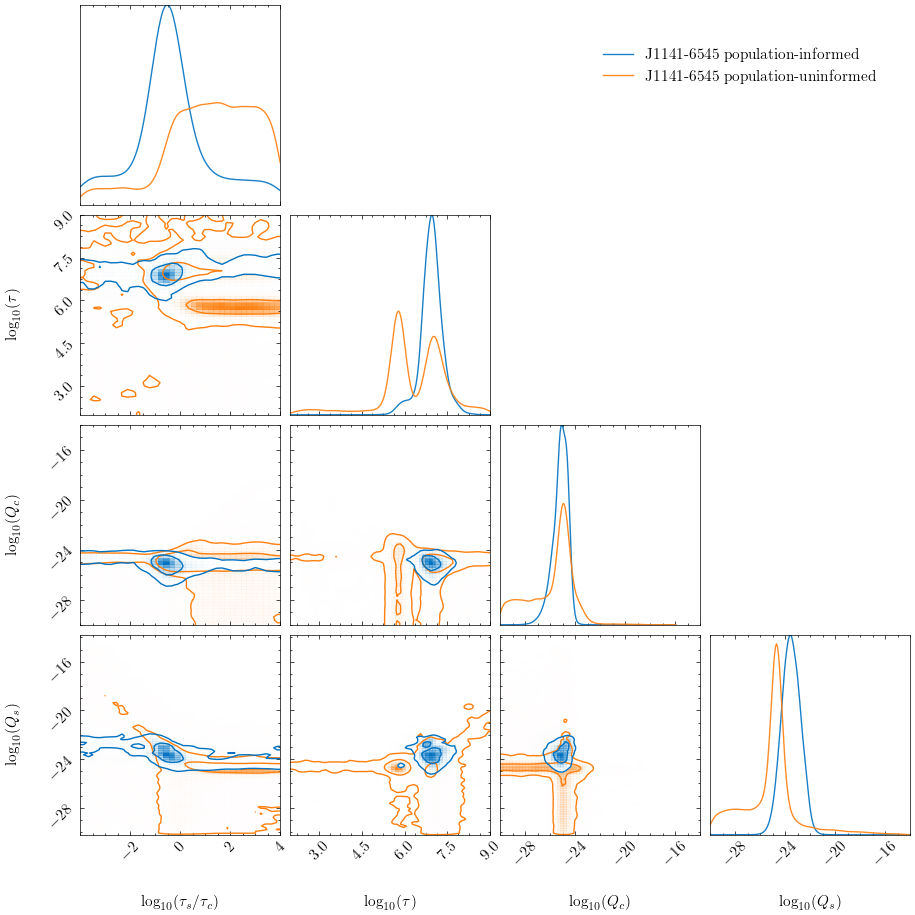

In [ ]:
EXAMPLE_PSR = ["J1141-6545"]

fig = hprp.reweight_posteriors_hist(
    overlay=True,
    restrict_to_psr=EXAMPLE_PSR,
    display_progress=True,
    restrict_to_params=[
        "ratio",
        "tau",
        "Qc",
        "Qs",
    ],
    levels=[1 - np.exp(-0.5), 1 - np.exp(-2)],
    figsize=(12, 12),
    plot_datapoints=False,
    do_kde=True,
    both_weighted_unweighted=True,
    smooth=1.0,
    colors=["#0072C1", "tab:orange"],
    # contour_kwargs={"alpha": 0.8},
    kde_kwargs={"alpha": 0.9},
)
legend_labels = [
    "J1141-6545 population-informed",
    "J1141-6545 population-uninformed",
]
plt.legend(
    labels=legend_labels,
    frameon=False,
    bbox_to_anchor=(0.9, 4),
)
plt.suptitle("")
plt.tight_layout()

Use `diptest` to check if $\tau$ posteriors are bimodal/multimodal

Loading results as generator


Streaming pulsar results: 2it [00:00,  5.65it/s]

J0729-1836 has a SIGNIFICANT dip with p-value 2.73e-05 in tau posterior


Streaming pulsar results: 9it [00:01,  6.09it/s]

J1057-5226 has a SIGNIFICANT dip with p-value 6.70e-05 in tau posterior


Streaming pulsar results: 14it [00:02,  6.35it/s]

J1141-6545 has a SIGNIFICANT dip with p-value 0.00e+00 in tau posterior


Streaming pulsar results: 16it [00:02,  5.38it/s]

J1320-5359 has a SIGNIFICANT dip with p-value 0.00e+00 in tau posterior


Streaming pulsar results: 30it [00:04,  6.99it/s]

J1759-2205 has a SIGNIFICANT dip with p-value 1.85e-04 in tau posterior


Streaming pulsar results: 33it [00:05,  6.41it/s]

J1829-1751 has a SIGNIFICANT dip with p-value 1.02e-03 in tau posterior


Streaming pulsar results: 41it [00:06,  6.15it/s]


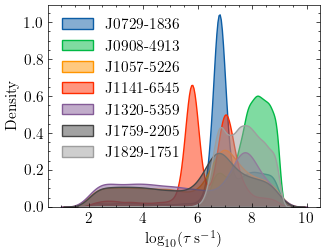

In [ ]:
import seaborn as sns

checktau_psrs = df_lnBF5_pkytau["PSRJ"].to_list() + df_lnBF5_rrtau["PSRJ"].to_list()
for psr, bilby_result in gen_load_bilby_results(
    hprp.hrchy_pop.filtered_data_path_parnt, restrict_to=checktau_psrs
):
    posteriors: pd.DataFrame = bilby_result.posterior
    _, pval = diptest.diptest(posteriors["tau"].apply(np.log10).to_numpy())
    if pval < 1 - 0.997:
        print(f"{psr} has a SIGNIFICANT dip with p-value {pval:.2e} in tau posterior")
    if pval < 1 - 0.997 or psr == "J0908-4913":
        sns.kdeplot(
            posteriors["tau"].apply(np.log10),
            label=psr,
            fill=True,
            alpha=0.5,
        )
        plt.xlabel(r"$\log_{10}(\tau\,\rm{s}^{-1})$")
        plt.legend()